# Mask R-CNN

MaskRCNN是一种概念简单、灵活、通用的目标实例分割框架，在检测出图像中目标的同时，还为每一个实例生成高质量掩码。这种称为Mask R-CNN的方法，通过添加与现有边框检测分支平行的预测目标掩码分支，达到扩展Faster R-CNN的目的。Mask R-CNN训练简单，运行速度达5fps，与Faster R-CNN相比，开销只有小幅上涨。此外，Mask R-CNN易于推广到其他任务。例如，允许在同一框架中预测人体姿势。 Mask R-CNN在COCO挑战赛的三个关键难点上都表现不俗，包括实例分割、边框目标检测和人物关键点检测。Mask R-CNN没有什么华而不实的附加功能，各任务的表现都优于现存所有单模型，包括COCO 2016挑战赛的胜出模型。


## 模型简介

MaskRCNN是一个两级目标检测网络，作为FasterRCNN的扩展模型，在现有的边框检测分支的基础上增加了一个预测目标掩码的分支。该网络采用区域候选网络（RPN），可与检测网络共享整个图像
的卷积特征，无需任何代价就可轻松计算候选区域。整个网络通过共享卷积特征，将RPN和掩码分支合并为一个网络。其模型骨干还可以选择轻量级网络Mobilenet。


## 官方库和第三方库的导入

我们首先导入案例依赖的官方库和第三方库。

In [1]:
import time
import os

import numpy as np
import mindspore.nn as nn
import mindspore.common.dtype as mstype
from mindspore.ops import operations as P
from mindspore.ops import functional as F
from mindspore.ops import composite as C
from mindspore.nn import layer as L
from mindspore.common.initializer import initializer
from mindspore import context, Tensor, Parameter
from mindspore import ParameterTuple
from mindspore.train.callback import Callback
from mindspore.nn.wrap.grad_reducer import DistributedGradReducer
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, TimeMonitor
from mindspore.train import Model
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.nn import Momentum
from mindspore.common import set_seed

from utils.config import config

## 数据处理

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore Vision套件。

### 数据准备

COCO2017是一个广泛应用的数据集，带有边框和像素级背景注释。这些注释可用于场景理解任务，如语义分割，目标检测和图像字幕制作。训练和评估的图像大小为118K和5K。

数据集大小：19G

训练：18G，118,000个图像

评估：1G，5000个图像

注释：241M；包括实例、字幕、人物关键点等

数据格式：图像及JSON文件

注：数据在dataset.py中处理。

首先，你需要下载 coco2017 数据集。

下载完成后，确保你的数据集存放符合如下路径。

In [2]:
!cat datasets.md

.
└─cocodataset
  ├─annotations
    ├─instance_train2017.json
    └─instance_val2017.json
  ├─val2017
  └─train2017

### 数据预处理

原始数据集中图像大小不一致，不方便统一读取和检测。我们首先统一图像大小。数据的注释信息保存在json文件中，我们需要读取出来给图像数据加label。

### 数据增强

在你开始训练模型之前。数据增强对于您的数据集以及创建训练数据和测试数据是必要的。对于coco数据集，你可以使用dataset.py为图像添加label，并将它们转换到MindRecord。MindRecord是一种MindSpore指定的数据格式，可以在某些场景下优化MindSpore的性能。

首先，我们创建MindRecord数据集保存和读取的地址。

In [3]:
from dataset.dataset import create_coco_dataset, data_to_mindrecord_byte_image

def create_mindrecord_dir(prefix, mindrecord_dir):
    """Create MindRecord Direction."""
    if not os.path.isdir(mindrecord_dir):
        os.makedirs(mindrecord_dir)
    if config.dataset == "coco":
        if os.path.isdir(config.data_root):
            print("Create Mindrecord.")
            data_to_mindrecord_byte_image("coco", True, prefix)
            print("Create Mindrecord Done, at {}".format(mindrecord_dir))
        else:
            raise Exception("coco_root not exits.")
    else:
        if os.path.isdir(config.IMAGE_DIR) and os.path.exists(config.ANNO_PATH):
            print("Create Mindrecord.")
            data_to_mindrecord_byte_image("other", True, prefix)
            print("Create Mindrecord Done, at {}".format(mindrecord_dir))
        else:
            raise Exception("IMAGE_DIR or ANNO_PATH not exits.")
    while not os.path.exists(mindrecord_file+".db"):
        time.sleep(5)


然后，加载数据集，调用dataset.py中的create_coco_dataset函数完成数据预处理和数据增强。

In [4]:
# Allocating memory Environment
device_target = config.device_target
rank = 0
device_num = 1
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

print("Start create dataset!")
# Call the interface for data processing
# It will generate mindrecord file in config.mindrecord_dir,
# and the file name is MaskRcnn.mindrecord0, 1, ... file_num.
prefix = "MaskRcnn.mindrecord"
mindrecord_dir = os.path.join(config.data_root, config.mindrecord_dir)
mindrecord_file = os.path.join(mindrecord_dir, prefix + "0")
if rank == 0 and not os.path.exists(mindrecord_file):
    create_mindrecord_dir(prefix, mindrecord_dir)
# When create MindDataset, using the fitst mindrecord file,
# such as MaskRcnn.mindrecord0.
dataset = create_coco_dataset(mindrecord_file, batch_size=config.batch_size, device_num=device_num, rank_id=rank)
dataset_size = dataset.get_dataset_size()
print("total images num: ", dataset_size)
print("Create dataset done!")

Start create dataset!
total images num:  51790
Create dataset done!


### 数据集可视化

运行以下代码观察数据增强后的图片。可以发现图片经过了旋转处理，并且图片的shape也已经转换为待输入网络的（N，C，H，W）格式，其中N代表样本数量，C代表图片通道，H和W代表图片的高和宽。

In [5]:
import numpy as np
import matplotlib.pyplot as plt

show_data = next(dataset.create_dict_iterator())

show_images = show_data["image"].asnumpy()
print(f'Image shape: {show_images.shape}')

plt.figure()

# 展示2张图片供参考
for i in range(1, 3):
    plt.subplot(1, 2, i)

    # 将图片转换HWC格式
    image_trans = np.transpose(show_images[i - 1], (1, 2, 0))
    image_trans = np.clip(image_trans, 0, 1)

    plt.imshow(image_trans[:, :], cmap=None)
    plt.xticks(rotation=180)
    plt.axis("off")

Image shape: (2, 3, 768, 1280)


ValueError: Unsupported dtype

<Figure size 432x288 with 2 Axes>

## 构建网络

![image1](images/framework.png)

前文提到Mask RCNN的模型骨干采用ResNet50（原文），通过添加与现有边框检测分支平行的预测目标掩模分支实现扩展Faster R-CNN，完成目标检测。

### 骨干网络

Mask R-CNN骨干网络的选择：ResNet, VGG, Mobilenet等。本项目中，使用了对ResNet为骨干的Mask RCNN进行了框架迁移。以及扩展了Mobilenet这种轻量级网络。

骨干网络：

1. Resnet（Deep residual network, ResNet），深度残差神经网络，卷积神经网络历史在具有划时代意义的神经网络。与Alexnet和VGG不同的是，网络结构上就有很大的改变，在大家为了提升卷积神经网络的性能在不断提升网络深度的时候，大家发现随着网络深度的提升，网络的效果变得越来越差，甚至出现了网络的退化问题，80层的网络比30层的效果还差，深度网络存在的梯度消失和爆炸问题越来越严重，这使得训练一个优异的深度学习模型变得更加艰难，在这种情况下，网络残差模块可以有效消除梯度消失和梯度爆炸问题。

![image2](images/resnet_block.png)

2. Mobilenetv1是一种轻量级的深度卷积网络，MobileNet的基本单元是深度级可分离卷积（depthwise separable convolution），将标准卷积分成两步。第一步 Depthwise convolution（DW）,也即逐通道的卷积，一个卷积核负责一个通道，一个通道只被一个卷积核“滤波”，则卷积核个数和通道数个数相同；第二步，Pointwise convolution（PW），将depthwise convolution得到的结果通过1x1卷积，再“串”起来。这样其实整体效果和一个标准卷积是差不多的，但是会大大减少计算量和模型参数量。其网络结构如下。

![image3](images/mobilenetv1.png)

原文中，使用Resnet为骨干网络。这里，我们也选择Resnet50作为骨干网络执行案例。

In [6]:
import numpy as np
import mindspore.nn as nn
import mindspore.common.dtype as mstype
from mindspore.ops import operations as P
from mindspore.common.tensor import Tensor
from mindspore.ops import functional as F
from mindspore import context

if context.get_context("device_target") == "Ascend":
    ms_cast_type = mstype.float16
else:
    ms_cast_type = mstype.float32


def weight_init_ones(shape):
    """
    Weight init.

    Args:
        shape(List): weights shape.

    Returns:
        Tensor, weights, default float32.
    """
    return Tensor(np.array(np.ones(shape).astype(np.float32) * 0.01).astype(np.float32))


def _conv(in_channels, out_channels, kernel_size=3, stride=1, padding=0, pad_mode='pad'):
    """
    Conv2D wrapper.

    Args:
        in_channels (int): The channel number of the input tensor of the Conv2d layer.
        out_channels (int): The channel number of the output tensor of the Conv2d layer.
        kernel_size (Union[int, tuple[int]]): Specifies the height and width of the 2D convolution kernel.
            The data type is an integer or a tuple of two integers. An integer represents the height
            and width of the convolution kernel. A tuple of two integers represents the height
            and width of the convolution kernel respectively. Default: 3.
        stride (Union[int, tuple[int]]): The movement stride of the 2D convolution kernel.
            The data type is an integer or a tuple of two integers. An integer represents the movement step size
            in both height and width directions. A tuple of two integers represents the movement step size in the height
            and width directions respectively. Default: 1.
        padding (Union[int, tuple[int]]): The number of padding on the height and width directions of the input.
            The data type is an integer or a tuple of four integers. If `padding` is an integer,
            then the top, bottom, left, and right padding are all equal to `padding`.
            If `padding` is a tuple of 4 integers, then the top, bottom, left, and right padding
            is equal to `padding[0]`, `padding[1]`, `padding[2]`, and `padding[3]` respectively.
            The value should be greater than or equal to 0. Default: 0.
        pad_mode (str): Specifies padding mode. The optional values are
            "same", "valid", "pad". Default: "pad".

    Outputs:
        Tensor, math '(N, C_{out}, H_{out}, W_{out})' or math '(N, H_{out}, W_{out}, C_{out})'.
    """
    shape = (out_channels, in_channels, kernel_size, kernel_size)
    weights = weight_init_ones(shape)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     pad_mode=pad_mode, weight_init=weights, has_bias=False).to_float(mstype.float32)


def _batch_norm2d_init(out_chls, momentum=0.1, affine=True, use_batch_statistics=True):
    """
    Batchnorm2D wrapper.

    Args:
        out_cls (int): The number of channels of the input tensor. Expected input size is (N, C, H, W),
            `C` represents the number of channels
        momentum (float): A floating hyperparameter of the momentum for the
            running_mean and running_var computation. Default: 0.1.
        affine (bool): A bool value. When set to True, gamma and beta can be learned. Default: True.
        use_batch_statistics (bool):

            - If true, use the mean value and variance value of current batch data and track running mean
              and running variance. Default: True.
            - If false, use the mean value and variance value of specified value, and not track statistical value.
            - If None, the use_batch_statistics is automatically set to true or false according to the training
              and evaluation mode. During training, the parameter is set to true, and during evaluation, the
              parameter is set to false.
    Outputs:
        Tensor, the normalized, scaled, offset tensor, of shape :math:'(N, C_{out}, H_{out}, W_{out})'.
    """
    gamma_init = Tensor(np.array(np.ones(out_chls)).astype(np.float32))
    beta_init = Tensor(np.array(np.ones(out_chls) * 0).astype(np.float32))
    moving_mean_init = Tensor(np.array(np.ones(out_chls) * 0).astype(np.float32))
    moving_var_init = Tensor(np.array(np.ones(out_chls)).astype(np.float32))

    return nn.BatchNorm2d(out_chls, momentum=momentum, affine=affine, gamma_init=gamma_init,
                          beta_init=beta_init, moving_mean_init=moving_mean_init,
                          moving_var_init=moving_var_init,
                          use_batch_statistics=use_batch_statistics)


class ResNetFea(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Tensor): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        weights_update (bool): Weight update flag.

    Inputs:
        - **x** (Tensor) - Input block.

    Outputs:
        Tensor, output block.

    Support Plarforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> ResNetFea(ResidualBlockUsing, [3, 4, 6, 3], [64, 256, 512, 1024], [256, 512, 1024, 2048], False)
    """
    def __init__(self, block, layer_nums, in_channels, out_channels, weights_update=False):
        super(ResNetFea, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of "
                             "layer_num, inchannel, outchannel list must be 4!")

        bn_training = False
        self.conv1 = _conv(3, 64, kernel_size=7, stride=2, padding=3, pad_mode='pad')
        self.bn1 = _batch_norm2d_init(64, affine=bn_training, use_batch_statistics=bn_training)
        self.relu = P.ReLU()
        self.maxpool = P.MaxPool(kernel_size=3, strides=2, pad_mode="SAME")
        self.weights_update = weights_update

        if not self.weights_update:
            self.conv1.weight.requires_grad = False

        self.layer1 = self._make_layer(block, layer_nums[0], in_channel=in_channels[0],
                                       out_channel=out_channels[0], stride=1, training=bn_training,
                                       weights_update=self.weights_update)
        self.layer2 = self._make_layer(block, layer_nums[1], in_channel=in_channels[1],
                                       out_channel=out_channels[1], stride=2,
                                       training=bn_training, weights_update=True)
        self.layer3 = self._make_layer(block, layer_nums[2], in_channel=in_channels[2],
                                       out_channel=out_channels[2], stride=2,
                                       training=bn_training, weights_update=True)
        self.layer4 = self._make_layer(block, layer_nums[3], in_channel=in_channels[3],
                                       out_channel=out_channels[3], stride=2,
                                       training=bn_training, weights_update=True)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride, training=False, weights_update=False):
        """
        Make layer for resnet backbone.

        Args:
            block (Tensor): ResNet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for convolutional layer.
            training(bool): Whether to do training. Default: False.
            weights_update(bool): Whether to update weights. Default: False.

        Returns:
            SequentialCell, Combine several layers toghter.

        Examples:
            >>> _make_layer(InvertedResidual, 4, 64, 64, 1)
        """
        layers = []
        down_sample = False
        if stride != 1 or in_channel != out_channel:
            down_sample = True
        resblk = block(in_channel, out_channel, stride=stride, down_sample=down_sample,
                       training=training, weights_update=weights_update)
        layers.append(resblk)

        for _ in range(1, layer_num):
            resblk = block(out_channel, out_channel, stride=1, training=training, weights_update=weights_update)
            layers.append(resblk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        """Construct ResNet architecture."""
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        identity = c2
        if not self.weights_update:
            identity = F.stop_gradient(c2)
        c3 = self.layer2(identity)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return identity, c3, c4, c5


class ResidualBlockUsing(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channels (int): Input channel.
        out_channels (int): Output channel.
        stride (int): Stride size for the initial convolutional layer. Default: 1.
        down_sample (bool): If to do the downsample in block. Default: False.
        momentum (float): Momentum for batchnorm layer. Default: 0.1.
        training (bool): Training flag. Default: False.
        weights_updata (bool): Weights update flag. Default: False.

    Inputs:
        - **x** (Tensor) - Input block.

    Outputs:
        Tensor, output block.

    Support Plarforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        ResidualBlockUsing(3, 256, stride=2, down_sample=True)
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, down_sample=False,
                 momentum=0.1, training=False, weights_update=False):
        super(ResidualBlockUsing, self).__init__()

        self.affine = weights_update

        out_chls = out_channels // self.expansion
        self.conv1 = _conv(in_channels, out_chls, kernel_size=1, stride=1, padding=0)
        self.bn1 = _batch_norm2d_init(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv2 = _conv(out_chls, out_chls, kernel_size=3, stride=stride, padding=1)
        self.bn2 = _batch_norm2d_init(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv3 = _conv(out_chls, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = _batch_norm2d_init(out_channels, momentum=momentum, affine=self.affine,
                                      use_batch_statistics=training)

        if training:
            self.bn1 = self.bn1.set_train()
            self.bn2 = self.bn2.set_train()
            self.bn3 = self.bn3.set_train()

        if not weights_update:
            self.conv1.weight.requires_grad = False
            self.conv2.weight.requires_grad = False
            self.conv3.weight.requires_grad = False

        self.relu = P.ReLU()
        self.downsample = down_sample
        if self.downsample:
            self.conv_down_sample = _conv(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
            self.bn_down_sample = _batch_norm2d_init(out_channels, momentum=momentum, affine=self.affine,
                                                     use_batch_statistics=training)
            if training:
                self.bn_down_sample = self.bn_down_sample.set_train()
            if not weights_update:
                self.conv_down_sample.weight.requires_grad = False
        self.add = P.Add()

    def construct(self, x):
        """Construct ResNet V1 residual block."""
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            identity = self.conv_down_sample(identity)
            identity = self.bn_down_sample(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out

### FPN网络

FPN网络（Feature Pyramid Network）同时利用低层特征高分辨率和高层特征的高语义信息，通过融合这些不同层的特征达到预测的效果。并且预测是在每个融合后的特征层上单独进行的，这和常规的特征融合方式不同。

骨干网络和FPN网络结合构成了Mask RCNN网络的卷积层。

In [7]:
def bias_init_zeros(shape):
    """Bias init method."""
    result = Tensor(np.array(np.zeros(shape).astype(np.float32)), dtype=mstype.float32)
    return result


def _conv(in_channels, out_channels, kernel_size=3, stride=1, padding=0, pad_mode='pad'):
    """
    Conv2D wrapper.

    Args:
        in_channels(int): Input channel num.
        out_channels(int): Output channel num.
        kernel_size(int): Kernel size. Default: 1.
        stride(int): Stride. Default: 1.
        padding(int): Padding range. Default: 0.
        pad_mode(bool): Padding model. Default: 'pad'.
        gain(int): Gain. Default: 1.

    Returns:
        Tensor, Convoluted result.
    """
    shape = (out_channels, in_channels, kernel_size, kernel_size)
    weights = initializer("XavierUniform", shape=shape, dtype=mstype.float32)
    shape_bias = (out_channels,)
    biass = bias_init_zeros(shape_bias)
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                     pad_mode=pad_mode, weight_init=weights, has_bias=True, bias_init=biass)


class FeatPyramidNeck(nn.Cell):
    """
    Feature pyramid network cell, usually uses as network neck.

    Applies the convolution on multiple, input feature maps
    and output feature map with same channel size. if required num of
    output larger then num of inputs, add extra maxpooling for further
    downsampling;

    Args:
        in_channels (tuple): Channel size of input feature maps.
        out_channels (int): Channel size output.
        num_outs (int): Num of output features.
    Inputs:
        - **x** (Tensor) - Input variant

    Outputs:
        Tuple, with tensors of same channel size.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> neck = FeatPyramidNeck([100,200,300], 50, 4)
        >>> input_data = (normal(0,0.1,(1,c,1280//(4*2**i), 768//(4*2**i)),
        ...               dtype=np.float32) for i, c in enumerate(config.fpn_in_channels))
        >>> out = neck(input_data)
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs):
        super(FeatPyramidNeck, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
        else:
            self.cast_type = mstype.float32

        self.num_outs = num_outs
        self.in_channels = in_channels
        self.fpn_layer = len(self.in_channels)

        assert not self.num_outs < len(in_channels)

        self.lateral_convs_list_ = []
        self.fpn_convs_ = []

        for _, channel in enumerate(in_channels):
            l_conv = _conv(channel, out_channels, kernel_size=1, stride=1, padding=0,
                           pad_mode='valid').to_float(self.cast_type)
            fpn_conv = _conv(out_channels, out_channels, kernel_size=3, stride=1, padding=0,
                             pad_mode='same').to_float(self.cast_type)
            self.lateral_convs_list_.append(l_conv)
            self.fpn_convs_.append(fpn_conv)
        self.lateral_convs_list = nn.layer.CellList(self.lateral_convs_list_)
        self.fpn_convs_list = nn.layer.CellList(self.fpn_convs_)
        self.interpolate1 = P.ResizeBilinear((48, 80))
        self.interpolate2 = P.ResizeBilinear((96, 160))
        self.interpolate3 = P.ResizeBilinear((192, 320))
        self.cast = P.Cast()
        self.maxpool = P.MaxPool(kernel_size=1, strides=2, pad_mode="same")

    def construct(self, inputs):
        """construction of Feature Pyramid Neck."""
        layers = ()
        for i in range(self.fpn_layer):
            layers += (self.lateral_convs_list[i](inputs[i]),)

        cast_layers = (layers[3],)
        cast_layers = \
            cast_layers + (layers[2] + self.cast(self.interpolate1(cast_layers[self.fpn_layer - 4]), self.cast_type),)
        cast_layers = \
            cast_layers + (layers[1] + self.cast(self.interpolate2(cast_layers[self.fpn_layer - 3]), self.cast_type),)
        cast_layers = \
            cast_layers + (layers[0] + self.cast(self.interpolate3(cast_layers[self.fpn_layer - 2]), self.cast_type),)

        layers_arranged = ()
        for i in range(self.fpn_layer - 1, -1, -1):
            layers_arranged = layers_arranged + (cast_layers[i],)

        outs = ()
        for i in range(self.fpn_layer):
            outs = outs + (self.fpn_convs_list[i](layers_arranged[i]),)

        for i in range(self.num_outs - self.fpn_layer):
            outs = outs + (self.maxpool(outs[3]),)
        return outs

### RPN网络

RPN第一次出现在世人眼中是在Faster RCNN这个结构中，专门用来提取候选框，在RCNN和Fast RCNN等物体检测架构中，用来提取候选框的方法通常是Selective Search，是比较传统的方法，而且比较耗时，在CPU上要2s一张图。所以作者提出RPN，专门用来提取候选框，一方面RPN耗时少，另一方面RPN可以很容易结合到Fast RCNN中，称为一个整体。

RPN网络主要输出项：

1. ROI：对应在特征层每个特征点产生4k个变量，其中4表示[dy, dx, dh, dw]四个边框平移缩放量。其中k表示4个边框，k=4。

2. scores：对应在特征层每个特征点产生2k个变量，其中2表示前景和北京概率。其中k表示3个边框，k=3。

In [8]:
from model.bbox_assign_sample import BboxAssignSample


class RpnRegClsBlock(nn.Cell):
    """
    Rpn reg cls block for rpn layer

    Args:
        in_channels (int): Input channels of shared convolution.
        feat_channels (int): Output channels of shared convolution.
        num_anchors (int): The anchor number.
        cls_out_channels (int): Output channels of classification convolution.
        weight_conv (Tensor): Weight init for rpn conv.
        bias_conv (Tensor): Bias init for rpn conv.
        weight_cls (Tensor): Weight init for rpn cls conv.
        bias_cls (Tensor): Bias init for rpn cls conv.
        weight_reg (Tensor): Weight init for rpn reg conv.
        bias_reg (Tensor): Bias init for rpn reg conv.

    Inputs:
        - **x** (Tensor) - input variant

    Outputs:
        Tensor, output tensor.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> x = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> weight_conv = Tensor(np.array([[[[0.2, 0.3], [0.4, 0.1]]]]), mindspore.float32)
        >>> bias_conv = Tensor(np.array([[[[0., 0.], [0., 0.]]]]), mindspore.float32)
        >>> weight_cls = Tensor(np.array([[[[0.2, 0.3], [0.4, 0.1]]]]), mindspore.float32)
        >>> bias_cls = Tensor(np.array([[[[0., 0.], [0., 0.]]]]), mindspore.float32)
        >>> weight_reg = Tensor(np.array([[[[0.2, 0.3], [0.4, 0.1]]]]), mindspore.float32)
        >>> bias_reg = Tensor(np.array([[[[0., 0.], [0., 0.]]]]), mindspore.float32)
        >>> rpn = RpnRegClsBlock(2, 2, 4, 4, )
        >>> rpn = ops.SingleRoIExtractor(2, 2, 0.5, 2, weight_conv, bias_conv,
        ...                              weight_cls, bias_cls, weight_reg, bias_reg)
        >>> output = rpn(x)
    """
    def __init__(self, in_channels, feat_channels, num_anchors, cls_out_channels, weight_conv,
                 bias_conv, weight_cls, bias_cls, weight_reg, bias_reg):
        super(RpnRegClsBlock, self).__init__()
        self.rpn_conv = nn.Conv2d(in_channels, feat_channels, kernel_size=3,
                                  stride=1, pad_mode='same',
                                  has_bias=True, weight_init=weight_conv,
                                  bias_init=bias_conv)
        self.relu = nn.ReLU()

        self.rpn_cls = nn.Conv2d(feat_channels, num_anchors * cls_out_channels,
                                 kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_cls,
                                 bias_init=bias_cls)
        self.rpn_reg = nn.Conv2d(feat_channels, num_anchors * 4,
                                 kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_reg,
                                 bias_init=bias_reg)

    def construct(self, x):
        """Construct Rpn reg cls block for rpn layer."""
        x = self.relu(self.rpn_conv(x))

        x1 = self.rpn_cls(x)
        x2 = self.rpn_reg(x)

        return x1, x2


class RPN(nn.Cell):
    """
    ROI proposal network..

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        in_channels (int): Input channels of shared convolution.
        feat_channels (int): Output channels of shared convolution.
        num_anchors (int): The anchor number.
        cls_out_channels (int): Output channels of classification convolution.

    Inputs:
        - **inputs** (Tensor) - Input variant.
        - **img_metas** (Tensor) - Img shape.
        - **anchor_list** (Tensor) - A list of anchors.
        - **gt_bboxes** (Tensor) - Ground truth bounding boxes.
        - **gt_labels** (Tensor) - Ground truth labels.
        - **gt_valids** (Tensor) - Ground truth validations.

    Outputs:
        Tuple, tuple of output tensor.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> RPN(config=config, batch_size=2, in_channels=256, feat_channels=1024,
        ...     num_anchors=3, cls_out_channels=512)
    """
    def __init__(self, config, batch_size, in_channels, feat_channels, num_anchors, cls_out_channels):
        super(RPN, self).__init__()
        cfg_rpn = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
            self.np_cast_type = np.float16
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.num_bboxes = cfg_rpn.num_bboxes
        self.slice_index = ()
        self.feature_anchor_shape = ()
        self.slice_index += (0,)
        index = 0
        for shape in cfg_rpn.feature_shapes:
            self.slice_index += (self.slice_index[index] + shape[0] * shape[1] * num_anchors,)
            self.feature_anchor_shape += (shape[0] * shape[1] * num_anchors * batch_size,)
            index += 1

        self.num_anchors = num_anchors
        self.batch_size = batch_size
        self.test_batch_size = cfg_rpn.test_batch_size
        self.num_layers = 5
        self.real_ratio = Tensor(np.ones((1, 1)).astype(self.np_cast_type))

        self.rpn_convs_list = nn.layer.CellList(self._make_rpn_layer(self.num_layers, in_channels, feat_channels,
                                                                     num_anchors, cls_out_channels))

        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
        self.concat = P.Concat(axis=0)
        self.fill = P.Fill()
        self.placeh1 = Tensor(np.ones((1,)).astype(self.np_cast_type))

        self.trans_shape = (0, 2, 3, 1)

        self.reshape_shape_reg = (-1, 4)
        self.reshape_shape_cls = (-1,)
        self.rpn_loss_reg_weight = Tensor(np.array(cfg_rpn.rpn_loss_reg_weight).astype(self.np_cast_type))
        self.rpn_loss_cls_weight = Tensor(np.array(cfg_rpn.rpn_loss_cls_weight).astype(self.np_cast_type))
        expected_total_size = cfg_rpn.num_expected_neg * self.batch_size
        self.num_expected_total = Tensor(np.array(expected_total_size).astype(self.np_cast_type))
        self.num_bboxes = cfg_rpn.num_bboxes
        self.get_targets = BboxAssignSample(cfg_rpn, self.batch_size, self.num_bboxes, False)
        self.check_valid = P.CheckValid()
        self.sum_loss = P.ReduceSum()
        self.loss_cls = P.SigmoidCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0/9.0)
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.tile = P.Tile()
        self.zeros_like = P.ZerosLike()
        self.loss = Tensor(np.zeros((1,)).astype(self.np_cast_type))
        self.clsloss = Tensor(np.zeros((1,)).astype(self.np_cast_type))
        self.regloss = Tensor(np.zeros((1,)).astype(self.np_cast_type))

    def _make_rpn_layer(self, num_layers, in_channels,
                        feat_channels, num_anchors, cls_out_channels):
        """
        Make rpn layer for rpn proposal network

        Args:
            num_layers (int): layer num.
            in_channels (int): Input channels of shared convolution.
            feat_channels (int): Output channels of shared convolution.
            num_anchors (int): The anchor number.
            cls_out_channels (int): Output channels of classification convolution.

        Returns:
            List, list of RpnRegClsBlock cells.
        """
        rpn_layer = []

        shp_weight_conv = (feat_channels, in_channels, 3, 3)
        shp_bias_conv = (feat_channels,)
        weight_conv = initializer('Normal', shape=shp_weight_conv, dtype=mstype.float32)
        bias_conv = initializer(0, shape=shp_bias_conv, dtype=mstype.float32)

        shp_weight_cls = (num_anchors * cls_out_channels, feat_channels, 1, 1)
        shp_bias_cls = (num_anchors * cls_out_channels,)
        weight_cls = initializer('Normal', shape=shp_weight_cls, dtype=mstype.float32)
        bias_cls = initializer(0, shape=shp_bias_cls, dtype=mstype.float32)

        shp_weight_reg = (num_anchors * 4, feat_channels, 1, 1)
        shp_bias_reg = (num_anchors * 4,)
        weight_reg = initializer('Normal', shape=shp_weight_reg, dtype=mstype.float32)
        bias_reg = initializer(0, shape=shp_bias_reg, dtype=mstype.float32)

        for i in range(num_layers):
            rpn_layer.append(RpnRegClsBlock(in_channels, feat_channels, num_anchors, cls_out_channels, weight_conv,
                                            bias_conv, weight_cls, bias_cls, weight_reg,
                                            bias_reg).to_float(self.cast_type))

        for i in range(1, num_layers):
            rpn_layer[i].rpn_conv.weight = rpn_layer[0].rpn_conv.weight
            rpn_layer[i].rpn_cls.weight = rpn_layer[0].rpn_cls.weight
            rpn_layer[i].rpn_reg.weight = rpn_layer[0].rpn_reg.weight

            rpn_layer[i].rpn_conv.bias = rpn_layer[0].rpn_conv.bias
            rpn_layer[i].rpn_cls.bias = rpn_layer[0].rpn_cls.bias
            rpn_layer[i].rpn_reg.bias = rpn_layer[0].rpn_reg.bias

        return rpn_layer

    def construct(self, inputs, img_metas, anchor_list, gt_bboxes, gt_labels, gt_valids):
        """Construct ROI Proposal Network."""
        loss_print = ()
        rpn_cls_score = ()
        rpn_bbox_pred = ()
        rpn_cls_score_total = ()
        rpn_bbox_pred_total = ()

        for i in range(self.num_layers):
            x1, x2 = self.rpn_convs_list[i](inputs[i])

            rpn_cls_score_total = rpn_cls_score_total + (x1,)
            rpn_bbox_pred_total = rpn_bbox_pred_total + (x2,)

            x1 = self.transpose(x1, self.trans_shape)
            x1 = self.reshape(x1, self.reshape_shape_cls)

            x2 = self.transpose(x2, self.trans_shape)
            x2 = self.reshape(x2, self.reshape_shape_reg)

            rpn_cls_score = rpn_cls_score + (x1,)
            rpn_bbox_pred = rpn_bbox_pred + (x2,)

        loss = self.loss
        clsloss = self.clsloss
        regloss = self.regloss
        bbox_targets = ()
        bbox_weights = ()
        labels = ()
        label_weights = ()

        output = ()
        if self.training:
            for i in range(self.batch_size):
                multi_level_flags = ()
                anchor_list_tuple = ()

                for j in range(self.num_layers):
                    res = self.cast(self.check_valid(anchor_list[j], self.squeeze(img_metas[i:i + 1:1, ::])),
                                    mstype.int32)
                    multi_level_flags = multi_level_flags + (res,)
                    anchor_list_tuple = anchor_list_tuple + (anchor_list[j],)

                valid_flag_list = self.concat(multi_level_flags)
                anchor_using_list = self.concat(anchor_list_tuple)

                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])
                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])

                bbox_target, bbox_weight, label, label_weight = \
                    self.get_targets(gt_bboxes_i, gt_labels_i, self.cast(valid_flag_list, mstype.bool_),
                                     anchor_using_list, gt_valids_i)

                bbox_weight = self.cast(bbox_weight, self.cast_type)
                label = self.cast(label, self.cast_type)
                label_weight = self.cast(label_weight, self.cast_type)

                for j in range(self.num_layers):
                    begin = self.slice_index[j]
                    end = self.slice_index[j + 1]
                    stride = 1
                    bbox_targets += (bbox_target[begin:end:stride, ::],)
                    bbox_weights += (bbox_weight[begin:end:stride],)
                    labels += (label[begin:end:stride],)
                    label_weights += (label_weight[begin:end:stride],)

            for i in range(self.num_layers):
                bbox_target_using = ()
                bbox_weight_using = ()
                label_using = ()
                label_weight_using = ()

                for j in range(self.batch_size):
                    bbox_target_using += (bbox_targets[i + (self.num_layers * j)],)
                    bbox_weight_using += (bbox_weights[i + (self.num_layers * j)],)
                    label_using += (labels[i + (self.num_layers * j)],)
                    label_weight_using += (label_weights[i + (self.num_layers * j)],)

                bbox_target_with_batchsize = self.concat(bbox_target_using)
                bbox_weight_with_batchsize = self.concat(bbox_weight_using)
                label_with_batchsize = self.concat(label_using)
                label_weight_with_batchsize = self.concat(label_weight_using)

                # stop
                bbox_target_ = F.stop_gradient(bbox_target_with_batchsize)
                bbox_weight_ = F.stop_gradient(bbox_weight_with_batchsize)
                label_ = F.stop_gradient(label_with_batchsize)
                label_weight_ = F.stop_gradient(label_weight_with_batchsize)

                cls_score_i = rpn_cls_score[i]
                reg_score_i = rpn_bbox_pred[i]

                loss_cls = self.loss_cls(cls_score_i, label_)
                loss_cls_item = loss_cls * label_weight_
                loss_cls_item = self.sum_loss(loss_cls_item, (0,)) / self.num_expected_total

                loss_reg = self.loss_bbox(reg_score_i, bbox_target_)
                bbox_weight_ = self.tile(self.reshape(bbox_weight_, (self.feature_anchor_shape[i], 1)), (1, 4))
                loss_reg = loss_reg * bbox_weight_
                loss_reg_item = self.sum_loss(loss_reg, (1,))
                loss_reg_item = self.sum_loss(loss_reg_item, (0,)) / self.num_expected_total

                loss_total = self.rpn_loss_cls_weight * loss_cls_item + self.rpn_loss_reg_weight * loss_reg_item

                loss += loss_total
                loss_print += (loss_total, loss_cls_item, loss_reg_item)
                clsloss += loss_cls_item
                regloss += loss_reg_item

                output = (loss, rpn_cls_score_total, rpn_bbox_pred_total,
                          clsloss, regloss, loss_print)
        else:
            output = (self.placeh1, rpn_cls_score_total, rpn_bbox_pred_total,
                      self.placeh1, self.placeh1, self.placeh1)
        return output

### ROI Align

ROI Align可以计算不同proposal对应到不同尺度下的特征，利用proposal对该特征进行剪裁、resize、pooling提取特征。

Mask-RCNN中使用的ROI Level校准:

$$
k=[k_0+\log_2{(\frac{\sqrt{wh}}{224/\sqrt{image\; area}})}]
$$

#### 解释

1. 由于Mask R-CNN训练数据的box和anchor都做了调整，所以ROI Level的计算部分也需要 $224/\sqrt{image\; area}$。其中，224应为输入图像尺寸的一半。

2. 计算得到的k即为ROI对应的level，level一共4个:

    1. $level=2$表示映射回特征 $P_{2}$，大小为原输入图像的 $1/4$。

    2. $level=3$表示映射回特征 $P_{3}$，大小为原输入图像的 $1/8$。

    3. $level=4$表示映射回特征 $P_{4}$，大小为原输入图像的 $1/16$。

    4. $level=5$表示映射回特征 $P_{5}$，大小为原输入图像的 $1/32$。

![image4](images/roi_align.png)

虚线网格表示特征图，实线表示RoI(在本例中为2×2个bin)，点表示每个容器中的4个采样点。RoIAlign通过双线性插值从特征图上附近的网格点(最近的4个)计算每个采样点的值。在ROI、4个bin或采样点中涉及的任何坐标上都不进行量化。

In [9]:
class ROIAlign(nn.Cell):
    """
    Extract RoI features from mulitiple feature map.

    Args:
        out_size_h (int): RoI height.
        out_size_w (int): RoI width.
        spatial_scale (int): RoI spatial scale.
        sample_num (int): RoI sample number. Default: 0.
        roi_align_mode (int): RoI align mode. Default: 1.

    Inputs:
        - **features** (Tensor) - The input features, whose shape must be :math:'(N, C, H, W)'.
        - **rois** (Tensor) - The shape is :math:'(rois_n, 5)'. With data type of float16 or float32.

    Outputs:
        Tensor, the shape is :math: '(rois_n, C, pooled_height, pooled_width)'.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> features = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> rois = Tensor(np.array([[0, 0.2, 0.3, 0.2, 0.3]]), mindspore.float32)
        >>> roi_align = ops.ROIAlign(2, 2, 0.5, 2)
        >>> output = roi_align(features, rois)
        >>> print(output)
        [[[[1.775 2.025]
           [2.275 2.525]]]]
    """
    def __init__(self, out_size_h, out_size_w, spatial_scale, sample_num=0, roi_align_mode=1):
        super(ROIAlign, self).__init__()

        self.out_size = (out_size_h, out_size_w)
        self.spatial_scale = float(spatial_scale)
        self.sample_num = int(sample_num)
        self.align_op = P.ROIAlign(self.out_size[0], self.out_size[1],
                                   self.spatial_scale, self.sample_num,
                                   roi_align_mode)

    def construct(self, features, rois):
        """Construct ROI Align"""
        return self.align_op(features, rois)

    def __repr__(self):
        format_str = self.__class__.__name__
        format_str += \
            '(out_size={}, spatial_scale={}, sample_num={}'.format(self.out_size, self.spatial_scale, self.sample_num)
        return format_str


class SingleRoIExtractor(nn.Cell):
    """
    Extract RoI features from a single level feature map.

    If there are multiple input feature levels, each RoI is mapped to a level according to its scale.

    Args:
        config (dict): Config
        out_channels (int): Output channels of RoI layers.
        featmap_strides (int): Strides of input feature maps.
        batch_size (int): Batchsize. Default: 1.
        finest_scale (int): Scale threshold of mapping to level 0. Default: 56.
        mask (bool): Specify ROIAlign for cls or mask branch. Default: False.

    Inputs:
        - **rois** (Tensor) - The shape is :math:'(rois_n, 5)'. With data type of float16 or float32.
        - **feat1** (Tensor) - The input features, whose shape must be :math:'(N, C, H, W)'.
        - **feat2** (Tensor) - The input features, whose shape must be :math:'(N, C, H, W)'.
        - **feat3** (Tensor) - The input features, whose shape must be :math:'(N, C, H, W)'.
        - **feat4** (Tensor) - The input features, whose shape must be :math:'(N, C, H, W)'.

    Outputs:
        Tensor, the shape is :math:'(rois_n, C, pooled_height, pooled_width)'.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> fea1 = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> fea2 = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> fea3 = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> fea4 = Tensor(np.array([[[[1., 2.], [3., 4.]]]]), mindspore.float32)
        >>> rois = Tensor(np.array([[0, 0.2, 0.3, 0.2, 0.3]]), mindspore.float32)
        >>> single_roi = ops.SingleRoIExtractor(conifg, 2, 1, 2, 2, mask)
        >>> output = single_roi(rois, fea1, fea2, fea3, fea4)
    """

    def __init__(self, config, roi_layer, out_channels, featmap_strides, batch_size=1, finest_scale=56, mask=False):
        super(SingleRoIExtractor, self).__init__()
        cfg = config
        self.train_batch_size = batch_size
        self.out_channels = out_channels
        self.featmap_strides = featmap_strides
        self.num_levels = len(self.featmap_strides)
        self.out_size = roi_layer.mask_out_size if mask else roi_layer.out_size
        self.mask = mask
        self.sample_num = roi_layer.sample_num
        self.roi_layers = self.build_roi_layers(self.featmap_strides)
        self.roi_layers = L.CellList(self.roi_layers)

        self.sqrt = P.Sqrt()
        self.log = P.Log()
        self.finest_scale_ = finest_scale
        self.clamp = C.clip_by_value

        self.cast = P.Cast()
        self.equal = P.Equal()
        self.select = P.Select()

        in_mode_16 = False
        self.dtype = np.float16 if in_mode_16 else np.float32
        self.ms_dtype = mstype.float16 if in_mode_16 else mstype.float32
        self.set_train_local(cfg, training=True)

    def set_train_local(self, config, training=True):
        """Set training flag."""
        self.training_local = training

        cfg = config
        # Init tensor
        roi_sample_num = cfg.num_expected_pos_stage2 if self.mask else cfg.roi_sample_num
        self.batch_size = roi_sample_num if self.training_local else cfg.rpn_max_num
        self.batch_size = self.train_batch_size*self.batch_size \
            if self.training_local else cfg.test_batch_size*self.batch_size
        self.ones = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype))
        finest_scale = np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * self.finest_scale_
        self.finest_scale = Tensor(finest_scale)
        self.epslion = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype)*self.dtype(1e-6))
        self.zeros = Tensor(np.array(np.zeros((self.batch_size, 1)), dtype=np.int32))
        self.max_levels = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=np.int32)*(self.num_levels-1))
        self.twos = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * 2)
        self.res_ = Tensor(np.array(np.zeros((self.batch_size, self.out_channels, self.out_size, self.out_size)),
                                    dtype=self.dtype))

    def num_inputs(self):
        """input number."""
        return len(self.featmap_strides)

    def log2(self, value):
        """calculate log2."""
        return self.log(value) / self.log(self.twos)

    def build_roi_layers(self, featmap_strides):
        """build ROI layers."""
        roi_layers = []
        for s in featmap_strides:
            layer_cls = ROIAlign(self.out_size, self.out_size, spatial_scale=1 / s,
                                 sample_num=self.sample_num, roi_align_mode=0)
            roi_layers.append(layer_cls)
        return roi_layers

    def _c_map_roi_levels(self, rois):
        """Map rois to corresponding feature levels by scales.

        - scale < finest_scale * 2: level 0
        - finest_scale * 2 <= scale < finest_scale * 4: level 1
        - finest_scale * 4 <= scale < finest_scale * 8: level 2
        - scale >= finest_scale * 8: level 3

        Args:
            rois (Tensor): Input RoIs, shape (k, 5).
            num_levels (int): Total level number.

        Returns:
            Tensor, Level index (0-based) of each RoI, shape (k, )
        """
        scale = self.sqrt(rois[::, 3:4:1] - rois[::, 1:2:1] + self.ones) * \
            self.sqrt(rois[::, 4:5:1] - rois[::, 2:3:1] + self.ones)

        target_lvls = self.log2(scale / self.finest_scale + self.epslion)
        target_lvls = P.Floor()(target_lvls)
        target_lvls = self.cast(target_lvls, mstype.int32)
        target_lvls = self.clamp(target_lvls, self.zeros, self.max_levels)

        return target_lvls

    def construct(self, rois, feat1, feat2, feat3, feat4):
        """Construct Single RoI Extractor"""
        feats = (feat1, feat2, feat3, feat4)
        res = self.res_
        target_lvls = self._c_map_roi_levels(rois)
        for i in range(self.num_levels):
            mask = self.equal(target_lvls, P.ScalarToArray()(i))
            mask = P.Reshape()(mask, (-1, 1, 1, 1))
            roi_feats_t = self.roi_layers[i](feats[i], rois)
            mask = \
                self.cast(P.Tile()(self.cast(mask, mstype.int32), (1, 256, self.out_size, self.out_size)), mstype.bool_)
            res = self.select(mask, roi_feats_t, res)

        return res

### Class/Bounding Box预测

Class/bounding box预测时，RPN输出一系列ROI，RoIAlign将ROI逐个对应会Resnet输出的5个特征层中的一个。再对该特征做相应的裁剪，resize操作得到对应的特征。再对该特征做进一步卷积，全连接最终输出预测。

In [10]:
class DenseNoTranpose(nn.Cell):
    """
    Dense method

    Args:
        input_channels (int): Channel size of input feature maps.
        output_channels (int): Channel size output.
        weight_init (tuple): Initialized values of weights.

    Inputs:
        - **x** (Tensor) - Input from the upper layer.

    Outputs:
        Tensor, dense result.

    Support Platforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> out_channels = 128
        >>> dense_notranspose = DenseNoTranpose(input_channels, output_channels, weights)
    """
    def __init__(self, input_channels, output_channels, weight_init):
        super(DenseNoTranpose, self).__init__()
        self.weight = Parameter(initializer(weight_init, [input_channels, output_channels], mstype.float32))
        self.bias = Parameter(initializer("zeros", [output_channels], mstype.float32))
        self.matmul = P.MatMul(transpose_b=False)
        self.bias_add = P.BiasAdd()

    def construct(self, x):
        """Construct Dense No Transpose."""
        output = self.bias_add(self.matmul(x, self.weight), self.bias)
        return output


class FpnCls(nn.Cell):
    """
    Dense layer of classification and box head

    Args:
        input_channels (int): Channel size of input feature maps.
        output_channels (int): Channel size output
        num_classes (int): Number of classes.
        pool_size (int): Pooling size.

    Inputs:
        - **x** (Tensor) - Input from the upper layer.

    Outputs:
        Tensor, dense result.

    Support Platforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> fpn_cls = FpnCls(256,128,81,2)
    """
    def __init__(self, input_channels, output_channels, num_classes, pool_size):
        super(FpnCls, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
        else:
            self.cast_type = mstype.float32

        representation_size = input_channels * pool_size * pool_size
        shape_0 = (output_channels, representation_size)
        weights_0 = initializer("XavierUniform", shape=shape_0[::-1], dtype=mstype.float32)
        shape_1 = (output_channels, output_channels)
        weights_1 = initializer("XavierUniform", shape=shape_1[::-1], dtype=mstype.float32)
        self.shared_fc_0 = DenseNoTranpose(representation_size, output_channels, weights_0).to_float(self.cast_type)
        self.shared_fc_1 = DenseNoTranpose(output_channels, output_channels, weights_1).to_float(self.cast_type)

        cls_weight = initializer('Normal', shape=[num_classes, output_channels][::-1], dtype=mstype.float32)
        reg_weight = initializer('Normal', shape=[num_classes * 4, output_channels][::-1], dtype=mstype.float32)
        self.cls_scores = DenseNoTranpose(output_channels, num_classes, cls_weight).to_float(self.cast_type)
        self.reg_scores = DenseNoTranpose(output_channels, num_classes * 4, reg_weight).to_float(self.cast_type)

        self.relu = P.ReLU()
        self.flatten = P.Flatten()

    def construct(self, x):
        """Construct FPNCls"""
        # two share fc layer
        x = self.flatten(x)

        x = self.relu(self.shared_fc_0(x))
        x = self.relu(self.shared_fc_1(x))

        # classifier head
        cls_scores = self.cls_scores(x)
        # bbox head
        reg_scores = self.reg_scores(x)

        return cls_scores, reg_scores


class RcnnCls(nn.Cell):
    """
    Rcnn for classification and box regression subnet.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_classes (int): Class number.
        target_means (list): Means for encode function. Default: (.0, .0, .0, .0]).
        target_stds (list): Stds for encode function. Default: (0.1, 0.1, 0.2, 0.2).

    Inputs:
        - **featuremap** (tuple) - Feature map.
        - **bbox_targets** (tuple) - A set of bounding box targets.
        - **labels** (tuple) - Ground truth labels.
        - **mask** (tuple) - Mask array.

    Outputs:
        Tuple, tuple of output tensor.

    Support Platforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> RcnnCls(config=config, representation_size = 1024,
        ...        batch_size=2, num_classes = 81,
        ...        target_means=(0., 0., 0., 0.),
        ...        target_stds=(0.1, 0.1, 0.2, 0.2))
    """

    def __init__(self, config, batch_size, num_classes, target_means=(0., 0., 0., 0.),
                 target_stds=(0.1, 0.1, 0.2, 0.2)):
        super(RcnnCls, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
            self.np_cast_type = np.float16
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        self.eps = 1e-5

        self.rcnn_loss_cls_weight = Tensor(np.array(cfg.rcnn_loss_cls_weight).astype(self.np_cast_type))
        self.rcnn_loss_reg_weight = Tensor(np.array(cfg.rcnn_loss_reg_weight).astype(self.np_cast_type))
        self.rcnn_fc_out_channels = cfg.rcnn_fc_out_channels
        self.target_means = target_means
        self.target_stds = target_stds
        self.num_classes = num_classes
        self.in_channels = cfg.rcnn_in_channels
        self.train_batch_size = batch_size
        self.test_batch_size = cfg.test_batch_size

        self.fpn_cls = FpnCls(self.in_channels, self.rcnn_fc_out_channels, self.num_classes, cfg.roi_layer.out_size)
        self.relu = P.ReLU()
        self.logicaland = P.LogicalAnd()
        self.loss_cls = P.SoftmaxCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0)
        self.loss_mask = P.SigmoidCrossEntropyWithLogits()
        self.reshape = P.Reshape()
        self.onehot = P.OneHot()
        self.greater = P.Greater()
        self.cast = P.Cast()
        self.sum_loss = P.ReduceSum()
        self.tile = P.Tile()
        self.expandims = P.ExpandDims()

        self.gather = P.GatherNd()
        self.argmax = P.ArgMaxWithValue(axis=1)

        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.value = Tensor(1.0, self.cast_type)

        self.num_bboxes = (cfg.num_expected_pos_stage2 + cfg.num_expected_neg_stage2) * batch_size

        rmv_first = np.ones((self.num_bboxes, self.num_classes))
        rmv_first[:, 0] = np.zeros((self.num_bboxes,))
        self.rmv_first_tensor = Tensor(rmv_first.astype(self.np_cast_type))

        self.num_bboxes_test = cfg.rpn_max_num * cfg.test_batch_size

    def construct(self, featuremap, bbox_targets, labels, mask):
        """Construct Rcnn for classification"""
        x_cls, x_reg = self.fpn_cls(featuremap)

        if self.training:
            bbox_weights = self.cast(self.logicaland(self.greater(labels, 0), mask), mstype.int32) * labels
            labels = self.cast(self.onehot(labels, self.num_classes, self.on_value, self.off_value), self.cast_type)
            bbox_targets = self.tile(self.expandims(bbox_targets, 1), (1, self.num_classes, 1))

            loss_cls, loss_reg = self.loss(x_cls, x_reg, bbox_targets, bbox_weights, labels, mask)
            out = (loss_cls, loss_reg)
        else:
            out = (x_cls, x_reg)

        return out

    def loss(self, cls_score, bbox_pred, bbox_targets, bbox_weights, labels, weights):
        """
        Loss method.
        Args:
            cls_score(Array): Classificaiton scores.
            bbox_pred(Array): Bounding box prediction.
            bbox_targets(Array): Bounding box GT target.
            bbox_weights(Array): Bounding box weights.
            labels(Array): GT labels.
            weights(Array): GT wieghts.

        Returns:
            loss_cls, float, classification loss.
            loss_reg, float, regression loss.
        """
        # loss_cls
        loss_cls, _ = self.loss_cls(cls_score, labels)
        weights = self.cast(weights, self.cast_type)
        loss_cls = loss_cls * weights
        loss_cls = self.sum_loss(loss_cls, (0,)) / (self.sum_loss(weights, (0,)) + self.eps)

        # loss_reg
        bbox_weights = self.cast(self.onehot(bbox_weights, self.num_classes, self.on_value, self.off_value),
                                 self.cast_type)
        bbox_weights = bbox_weights * self.rmv_first_tensor
        pos_bbox_pred = self.reshape(bbox_pred, (self.num_bboxes, -1, 4))
        loss_reg = self.loss_bbox(pos_bbox_pred, bbox_targets)
        loss_reg = self.sum_loss(loss_reg, (2,))
        loss_reg = loss_reg * bbox_weights
        loss_reg = loss_reg / (self.sum_loss(weights, (0,)) + self.eps)
        loss_reg = self.sum_loss(loss_reg, (0, 1))

        return loss_cls, loss_reg

### Mask预测

对RoIAlign输出的特征进行一系列的卷积，转置卷积，最后输出mask的预测结果。

In [11]:
def _conv(in_channels, out_channels, kernel_size=1, stride=1, padding=0, pad_mode='pad', gain=1):
    """
    Conv2D wrapper.

    Args:
        in_channels(int): Input channel num.
        out_channels(int): Output channel num.
        kernel_size(int): Kernel size. Default: 1
        stride(int): Stride. Default: 1
        padding(int): Padding range. Default: 0
        pad_mode(bool): Padding model. Default: 'pad'
        gain(int): Gain. Default: 1

    Returns:
        Tensor, Convoluted result.
    """
    shape = (out_channels, in_channels, kernel_size, kernel_size)
    # xavier_normal
    fan_in = in_channels * kernel_size * kernel_size
    fan_out = out_channels * kernel_size * kernel_size
    std = gain * (2 / (fan_in + fan_out)) ** 0.5
    weights = Tensor(np.random.normal(loc=0.0, scale=std, size=shape).astype(np.float32))
    shape_bias = (out_channels,)
    bias = Tensor(np.array(np.zeros(shape_bias)).astype(np.float32))
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                     pad_mode=pad_mode, weight_init=weights, has_bias=True, bias_init=bias)


def _conv_transpose(in_channels, out_channels, kernel_size=1, stride=1, padding=0, pad_mode='pad', gain=1):
    """
    ConvTranspose wrapper.

    Args:
        in_channels(int): Input channel num.
        out_channels(int): Output channel num.
        kernel_size(int): Kernel size. Default: 1
        stride(int): Stride. Default: 1
        padding(int): Padding range. Default: 0
        pad_mode(bool): Padding model. Default: 'pad'
        gain(int): Gain. Default: 1

    Returns:
        Tensor, Convoluted Transposed result.
    """
    shape = (out_channels, in_channels, kernel_size, kernel_size)
    # xavier_normal
    fan_in = in_channels * kernel_size * kernel_size
    fan_out = out_channels * kernel_size * kernel_size
    std = gain * (2 / (fan_in + fan_out)) ** 0.5
    weights = Tensor(np.random.normal(loc=0.0, scale=std, size=shape).astype(np.float32))
    shape_bias = (out_channels,)
    bias = Tensor(np.array(np.zeros(shape_bias)).astype(np.float32))
    return nn.Conv2dTranspose(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                              pad_mode=pad_mode, weight_init=weights, has_bias=True, bias_init=bias)


class FpnMask(nn.Cell):
    """
    Conv layers of mask head

    Args:
        input_channels (int): Channel size of input feature maps.
        output_channels (int): Channel size output
        num_classes (int): Number of classes.

    Inputs:
        - **x** (Tensor) - Input from the upper layer.

    Outputs:
        Tuple, tuple of output tensor.

    Support Platforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> FpnMask(input_channels=256, output_channels=256, num_classes=81)
    """
    def __init__(self, input_channels, output_channels, num_classes):
        super(FpnMask, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
        else:
            self.cast_type = mstype.float32

        self.mask_conv1 = _conv(input_channels, output_channels,
                                kernel_size=3, gain=2 ** 0.5,
                                pad_mode="same").to_float(self.cast_type)
        self.mask_relu1 = P.ReLU()

        self.mask_conv2 = _conv(output_channels, output_channels,
                                kernel_size=3, gain=2 ** 0.5,
                                pad_mode="same").to_float(self.cast_type)
        self.mask_relu2 = P.ReLU()

        self.mask_conv3 = _conv(output_channels, output_channels,
                                kernel_size=3, gain=2 ** 0.5,
                                pad_mode="same").to_float(self.cast_type)
        self.mask_relu3 = P.ReLU()

        self.mask_conv4 = _conv(output_channels, output_channels,
                                kernel_size=3, gain=2 ** 0.5,
                                pad_mode="same").to_float(self.cast_type)
        self.mask_relu4 = P.ReLU()

        self.mask_deconv5 = _conv_transpose(output_channels, output_channels, kernel_size=2, gain=2 ** 0.5,
                                            stride=2, pad_mode="valid").to_float(self.cast_type)
        self.mask_relu5 = P.ReLU()
        self.mask_conv6 = _conv(output_channels, num_classes, kernel_size=1, stride=1, gain=2,
                                pad_mode="valid").to_float(self.cast_type)

    def construct(self, x):
        """Construct convolutional layers of mask heads. """
        x = self.mask_conv1(x)
        x = self.mask_relu1(x)

        x = self.mask_conv2(x)
        x = self.mask_relu2(x)

        x = self.mask_conv3(x)
        x = self.mask_relu3(x)

        x = self.mask_conv4(x)
        x = self.mask_relu4(x)

        x = self.mask_deconv5(x)
        x = self.mask_relu5(x)

        x = self.mask_conv6(x)

        return x


class RcnnMask(nn.Cell):
    """
    Rcnn for mask subnet.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_classes (int): Class number.
        target_means (list): Means for encode function. Default: (.0, .0, .0, .0]).
        target_stds (list): Stds for encode function. Default: (0.1, 0.1, 0.2, 0.2).

    Inputs:
        - **mask_featuremap** (tuple) - Masked feature map
        - **labels** (tuple) - Ground truth labels. Default: None
        - **mask** (tuple) - Mask map. Default: None
        - **mask_fb_targets** (tuple) - Masked targets. Default: None

    Outputs:
        Tuple, tuple of output tensor.

    Examples:
        >>> RcnnMask(config=config, representation_size = 1024,
        ...          batch_size=2, num_classes = 81,
        ...          target_means=(0., 0., 0., 0.),
        ...          target_stds=(0.1, 0.1, 0.2, 0.2))
    """

    def __init__(self, config, batch_size, num_classes, target_means=(0., 0., 0., 0.),
                 target_stds=(0.1, 0.1, 0.2, 0.2)):
        super(RcnnMask, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
            self.np_cast_type = np.float16
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        self.eps = 1e-5

        self.rcnn_loss_mask_fb_weight = Tensor(np.array(cfg.rcnn_loss_mask_fb_weight).astype(self.np_cast_type))
        self.rcnn_mask_out_channels = cfg.rcnn_mask_out_channels
        self.target_means = target_means
        self.target_stds = target_stds
        self.num_classes = num_classes
        self.in_channels = cfg.rcnn_in_channels

        self.fpn_mask = FpnMask(self.in_channels, self.rcnn_mask_out_channels, self.num_classes)

        self.logicaland = P.LogicalAnd()
        self.loss_mask = P.SigmoidCrossEntropyWithLogits()
        self.onehot = P.OneHot()
        self.greater = P.Greater()
        self.cast = P.Cast()
        self.sum_loss = P.ReduceSum()
        self.tile = P.Tile()
        self.expandims = P.ExpandDims()

        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)

        self.num_bboxes = cfg.num_expected_pos_stage2 * batch_size
        rmv_first = np.ones((self.num_bboxes, self.num_classes))
        rmv_first[:, 0] = np.zeros((self.num_bboxes,))
        self.rmv_first_tensor = Tensor(rmv_first.astype(self.np_cast_type))
        self.mean_loss = P.ReduceMean()

    def construct(self, mask_featuremap, labels=None, mask=None, mask_fb_targets=None):
        """Construct Rcnn Mask."""
        x_mask_fb = self.fpn_mask(mask_featuremap)

        if self.training:
            bbox_weights = self.cast(self.logicaland(self.greater(labels, 0), mask), mstype.int32) * labels
            mask_fb_targets = self.tile(self.expandims(mask_fb_targets, 1), (1, self.num_classes, 1, 1))

            loss_mask_fb = self.loss(x_mask_fb, bbox_weights, mask, mask_fb_targets)
            out = loss_mask_fb
        else:
            out = x_mask_fb

        return out

    def loss(self, masks_fb_pred, bbox_weights, weights, masks_fb_targets):
        """
        Loss method.

        Args:
            mask_fb_pred (Tensor): Mask feedback prediction.
            bbox_weights (Tensor): Bounding box weights.
            weights (Tensor): GT weights.
            masks_fb_targets (Tensor): Mask feedback targets.

        Returns:
            Tensor, loss mask feedback result.
        """
        weights = self.cast(weights, self.cast_type)
        bbox_weights = \
            self.cast(self.onehot(bbox_weights, self.num_classes, self.on_value, self.off_value), self.cast_type)
        bbox_weights = bbox_weights * self.rmv_first_tensor

        # loss_mask_fb
        masks_fb_targets = self.cast(masks_fb_targets, self.cast_type)
        loss_mask_fb = self.loss_mask(masks_fb_pred, masks_fb_targets)
        loss_mask_fb = self.mean_loss(loss_mask_fb, (2, 3))
        loss_mask_fb = loss_mask_fb * bbox_weights
        loss_mask_fb = loss_mask_fb / (self.sum_loss(weights, (0,)) + self.eps)
        loss_mask_fb = self.sum_loss(loss_mask_fb, (0, 1))

        return loss_mask_fb

### Mask RCNN模型

我们将卷积层，RPN层，RoIAlign层，Bbox预测层和Mask预测层连接起来，构建Mask RCNN网络。

In [12]:
from model.bbox_assign_sample_stage2 import BboxAssignSampleForRcnn
from model.fpn_neck import FeatPyramidNeck
from model.proposal_generator import Proposal
from model.rcnn_cls import RcnnCls
from model.rcnn_mask import RcnnMask
from model.rpn import RPN
from model.roi_align import SingleRoIExtractor
from model.anchor_generator import AnchorGenerator
from model.resnet50 import ResNetFea, ResidualBlockUsing


class MaskRcnnResnet50(nn.Cell):
    """
    MaskRcnn Network.

    Note:
        backbone = resnet50

    Args:
        config (dict): Config.

    Inputs:
        - **img_data** (Tensor) - Image data.
        - **img_metas** (Tensor) - Image shapes.
        - **gt_bboxes** (Tensor) - GT boudning boxes.
        - **gt_labels** (Tensor) - GT labels.
        - **gt_valids** (Tensor) - GT validations.
        - **gt_masks** (Tensor) - GT masks.

    Outputs:
        Function, return a tuple of output tensor.

    Support Plarforms:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> net = MaskRcnnResnet50(config)
    """
    def __init__(self, config):
        super(MaskRcnnResnet50, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float16
            self.np_cast_type = np.float16
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.train_batch_size = config.batch_size
        self.num_classes = config.num_classes
        self.anchor_scales = config.anchor_scales
        self.anchor_ratios = config.anchor_ratios
        self.anchor_strides = config.anchor_strides
        self.target_means = tuple(config.rcnn_target_means)
        self.target_stds = tuple(config.rcnn_target_stds)

        # Anchor generator
        anchor_base_sizes = None
        self.anchor_base_sizes = list(
            self.anchor_strides) if anchor_base_sizes is None else anchor_base_sizes

        self.anchor_generators = []
        for anchor_base in self.anchor_base_sizes:
            self.anchor_generators.append(AnchorGenerator(anchor_base, self.anchor_scales, self.anchor_ratios))

        self.num_anchors = len(self.anchor_ratios) * len(self.anchor_scales)

        featmap_sizes = config.feature_shapes
        assert len(featmap_sizes) == len(self.anchor_generators)

        self.anchor_list = self.get_anchors(featmap_sizes)

        # Backbone resnet50
        self.backbone = ResNetFea(ResidualBlockUsing, config.resnet_block, config.resnet_in_channels,
                                  config.resnet_out_channels, False)
        # Fpn
        self.fpn_ncek = FeatPyramidNeck(config.fpn_in_channels, config.fpn_out_channels, config.fpn_num_outs)

        # Rpn and rpn loss
        self.gt_labels_stage1 = Tensor(np.ones((self.train_batch_size, config.num_gts)).astype(np.uint8))
        self.rpn_with_loss = RPN(config, self.train_batch_size, config.rpn_in_channels,
                                 config.rpn_feat_channels, config.num_anchors, config.rpn_cls_out_channels)

        # Proposal
        self.proposal_generator = Proposal(config, self.train_batch_size,
                                           config.activate_num_classes,
                                           config.use_sigmoid_cls)
        self.proposal_generator.set_train_local(config, True)
        self.proposal_generator_test = Proposal(config, config.test_batch_size,
                                                config.activate_num_classes,
                                                config.use_sigmoid_cls)
        self.proposal_generator_test.set_train_local(config, False)

        # Assign and sampler stage two
        self.bbox_assigner_sampler_for_rcnn = \
            BboxAssignSampleForRcnn(config, self.train_batch_size, config.num_bboxes_stage2, True)
        self.decode = P.BoundingBoxDecode(max_shape=(768, 1280), means=self.target_means, stds=self.target_stds)

        # Roi
        self.init_roi(config)

        # Rcnn
        self.rcnn_cls = RcnnCls(config, self.train_batch_size, self.num_classes)
        self.rcnn_mask = RcnnMask(config, self.train_batch_size, self.num_classes)

        # Op declare
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()

        self.concat = P.Concat(axis=0)
        self.concat_1 = P.Concat(axis=1)
        self.concat_2 = P.Concat(axis=2)
        self.reshape = P.Reshape()
        self.select = P.Select()
        self.greater = P.Greater()
        self.transpose = P.Transpose()

        # Test mode
        self.init_test_mode(config)

        # Improve speed
        self.concat_start = min(self.num_classes - 2, 55)
        self.concat_end = (self.num_classes - 1)

        # Init tensor
        self.init_tensor(config)

    def init_roi(self, config):
        """initialize roi aligners."""
        self.roi_align = SingleRoIExtractor(config, config.roi_layer, config.roi_align_out_channels,
                                            config.roi_align_featmap_strides, self.train_batch_size,
                                            config.roi_align_finest_scale, mask=False)
        self.roi_align.set_train_local(config, True)

        self.roi_align_mask = SingleRoIExtractor(config, config.roi_layer, config.roi_align_out_channels,
                                                 config.roi_align_featmap_strides, self.train_batch_size,
                                                 config.roi_align_finest_scale, mask=True)
        self.roi_align_mask.set_train_local(config, True)

        self.roi_align_test = SingleRoIExtractor(config, config.roi_layer, config.roi_align_out_channels,
                                                 config.roi_align_featmap_strides, 1,
                                                 config.roi_align_finest_scale, mask=False)
        self.roi_align_test.set_train_local(config, False)

        self.roi_align_mask_test = SingleRoIExtractor(config, config.roi_layer, config.roi_align_out_channels,
                                                      config.roi_align_featmap_strides, 1,
                                                      config.roi_align_finest_scale, mask=True)
        self.roi_align_mask_test.set_train_local(config, False)

    def init_test_mode(self, config):
        """"initialize the test mode."""
        self.test_batch_size = config.test_batch_size
        self.split = P.Split(axis=0, output_num=self.test_batch_size)
        self.split_shape = P.Split(axis=0, output_num=4)
        self.split_scores = P.Split(axis=1, output_num=self.num_classes)
        self.split_fb_mask = P.Split(axis=1, output_num=self.num_classes)
        self.split_cls = P.Split(axis=0, output_num=self.num_classes-1)
        self.tile = P.Tile()
        self.gather = P.GatherNd()

        self.rpn_max_num = config.rpn_max_num

        self.zeros_for_nms = Tensor(np.zeros((self.rpn_max_num, 3)).astype(self.np_cast_type))
        self.ones_mask = np.ones((self.rpn_max_num, 1)).astype(np.bool)
        self.zeros_mask = np.zeros((self.rpn_max_num, 1)).astype(np.bool)
        self.bbox_mask = Tensor(np.concatenate((self.ones_mask, self.zeros_mask,
                                                self.ones_mask, self.zeros_mask), axis=1))
        self.nms_pad_mask = Tensor(np.concatenate((self.ones_mask, self.ones_mask,
                                                   self.ones_mask, self.ones_mask,
                                                   self.zeros_mask), axis=1))

        self.test_score_thresh = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * \
                                        config.test_score_thr)
        self.test_score_zeros = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * 0)
        self.test_box_zeros = Tensor(np.ones((self.rpn_max_num, 4)).astype(self.np_cast_type) * -1)
        self.test_iou_thr = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * config.test_iou_thr)
        self.test_max_per_img = config.test_max_per_img
        self.nms_test = P.NMSWithMask(config.test_iou_thr)
        self.softmax = P.Softmax(axis=1)
        self.logicand = P.LogicalAnd()
        self.oneslike = P.OnesLike()
        self.test_topk = P.TopK(sorted=True)
        self.test_num_proposal = self.test_batch_size * self.rpn_max_num

    def init_tensor(self, config):
        """initialize the tensors."""
        roi_align_index = [np.array(np.ones((config.num_expected_pos_stage2 + \
                                             config.num_expected_neg_stage2, 1)) * i,
                                    dtype=self.np_cast_type) for i in range(self.train_batch_size)]

        roi_align_index_test = [np.array(np.ones((config.rpn_max_num, 1)) * i,
                                         dtype=self.np_cast_type) for i in range(self.test_batch_size)]

        self.roi_align_index_tensor = Tensor(np.concatenate(roi_align_index))
        self.roi_align_index_test_tensor = Tensor(np.concatenate(roi_align_index_test))

        roi_align_index_pos = [np.array(np.ones((config.num_expected_pos_stage2, 1)) * i,
                                        dtype=self.np_cast_type) for i in range(self.train_batch_size)]
        self.roi_align_index_tensor_pos = Tensor(np.concatenate(roi_align_index_pos))

        self.rcnn_loss_cls_weight = Tensor(np.array(config.rcnn_loss_cls_weight).astype(self.np_cast_type))
        self.rcnn_loss_reg_weight = Tensor(np.array(config.rcnn_loss_reg_weight).astype(self.np_cast_type))
        self.rcnn_loss_mask_fb_weight = Tensor(np.array(config.rcnn_loss_mask_fb_weight).astype(self.np_cast_type))

        self.argmax_with_value = P.ArgMaxWithValue(axis=1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.onehot = P.OneHot()
        self.reducesum = P.ReduceSum()
        self.sigmoid = P.Sigmoid()
        self.expand_dims = P.ExpandDims()
        self.test_mask_fb_zeros = Tensor(np.zeros((self.rpn_max_num, 28, 28)).astype(self.np_cast_type))
        self.value = Tensor(1.0, self.cast_type)

    def construct(self, img_data, img_metas, gt_bboxes, gt_labels, gt_valids, gt_masks):
        """Construct for Mask R-CNN net."""
        x = self.backbone(img_data)
        x = self.fpn_ncek(x)

        rpn_loss, cls_score, bbox_pred, rpn_cls_loss, rpn_reg_loss, _ = self.rpn_with_loss(x, img_metas,
                                                                                           self.anchor_list,
                                                                                           gt_bboxes,
                                                                                           self.gt_labels_stage1,
                                                                                           gt_valids)

        if self.training:
            proposal, proposal_mask = self.proposal_generator(cls_score, bbox_pred, self.anchor_list)
        else:
            proposal, proposal_mask = self.proposal_generator_test(cls_score, bbox_pred, self.anchor_list)

        gt_labels = self.cast(gt_labels, mstype.int32)
        gt_valids = self.cast(gt_valids, mstype.int32)
        bboxes_tuple = ()
        deltas_tuple = ()
        labels_tuple = ()
        mask_tuple = ()

        pos_bboxes_tuple = ()
        pos_mask_fb_tuple = ()
        pos_labels_tuple = ()
        pos_mask_tuple = ()

        if self.training:
            for i in range(self.train_batch_size):
                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])

                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_labels_i = self.cast(gt_labels_i, mstype.uint8)

                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])
                gt_valids_i = self.cast(gt_valids_i, mstype.bool_)

                gt_masks_i = self.squeeze(gt_masks[i:i + 1:1, ::])
                gt_masks_i = self.cast(gt_masks_i, mstype.bool_)

                bboxes, deltas, labels, mask, pos_bboxes, pos_mask_fb, pos_labels, pos_mask = \
                    self.bbox_assigner_sampler_for_rcnn(gt_bboxes_i, gt_labels_i, proposal_mask[i],
                                                        proposal[i][::, 0:4:1], gt_valids_i, gt_masks_i)
                bboxes_tuple += (bboxes,)
                deltas_tuple += (deltas,)
                labels_tuple += (labels,)
                mask_tuple += (mask,)

                pos_bboxes_tuple += (pos_bboxes,)
                pos_mask_fb_tuple += (pos_mask_fb,)
                pos_labels_tuple += (pos_labels,)
                pos_mask_tuple += (pos_mask,)

            bbox_targets = self.concat(deltas_tuple)
            rcnn_labels = self.concat(labels_tuple)
            bbox_targets = F.stop_gradient(bbox_targets)
            rcnn_labels = F.stop_gradient(rcnn_labels)
            rcnn_labels = self.cast(rcnn_labels, mstype.int32)

            rcnn_pos_masks_fb = self.concat(pos_mask_fb_tuple)
            rcnn_pos_masks_fb = F.stop_gradient(rcnn_pos_masks_fb)
            rcnn_pos_labels = self.concat(pos_labels_tuple)
            rcnn_pos_labels = F.stop_gradient(rcnn_pos_labels)
            rcnn_pos_labels = self.cast(rcnn_pos_labels, mstype.int32)
        else:
            mask_tuple += proposal_mask
            bbox_targets = proposal_mask
            rcnn_labels = proposal_mask

            rcnn_pos_masks_fb = proposal_mask
            rcnn_pos_labels = proposal_mask
            for p_i in proposal:
                bboxes_tuple += (p_i[::, 0:4:1],)

        bboxes_all, rois, pos_rois = self.rois(bboxes_tuple, pos_bboxes_tuple)

        if self.training:
            roi_feats = self.roi_align(rois,
                                       self.cast(x[0], mstype.float32),
                                       self.cast(x[1], mstype.float32),
                                       self.cast(x[2], mstype.float32),
                                       self.cast(x[3], mstype.float32))
        else:
            roi_feats = self.roi_align_test(rois,
                                            self.cast(x[0], mstype.float32),
                                            self.cast(x[1], mstype.float32),
                                            self.cast(x[2], mstype.float32),
                                            self.cast(x[3], mstype.float32))


        roi_feats = self.cast(roi_feats, self.cast_type)
        rcnn_masks = self.concat(mask_tuple)
        rcnn_masks = F.stop_gradient(rcnn_masks)
        rcnn_mask_squeeze = self.squeeze(self.cast(rcnn_masks, mstype.bool_))

        rcnn_pos_masks = self.concat(pos_mask_tuple)
        rcnn_pos_masks = F.stop_gradient(rcnn_pos_masks)
        rcnn_pos_mask_squeeze = self.squeeze(self.cast(rcnn_pos_masks, mstype.bool_))

        rcnn_cls_loss, rcnn_reg_loss = self.rcnn_cls(roi_feats, bbox_targets, rcnn_labels, rcnn_mask_squeeze)

        if self.training:
            return self.get_output_train(pos_rois, x, rcnn_pos_labels, rcnn_pos_mask_squeeze, rcnn_pos_masks_fb,
                                         rpn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss)

        return self.get_output_eval(x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, img_metas)

    def rois(self, bboxes_tuple, pos_bboxes_tuple):
        """"initialize the rois."""
        pos_rois = None
        if self.training:
            if self.train_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
                pos_bboxes_all = self.concat(pos_bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
                pos_bboxes_all = pos_bboxes_tuple[0]
            rois = self.concat_1((self.roi_align_index_tensor, bboxes_all))
            pos_rois = self.concat_1((self.roi_align_index_tensor_pos, pos_bboxes_all))
            pos_rois = self.cast(pos_rois, mstype.float32)
            pos_rois = F.stop_gradient(pos_rois)
        else:
            if self.test_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
            rois = self.concat_1((self.roi_align_index_test_tensor, bboxes_all))

        rois = self.cast(rois, mstype.float32)
        rois = F.stop_gradient(rois)

        return bboxes_all, rois, pos_rois

    def get_output_train(self, pos_rois, x, rcnn_pos_labels, rcnn_pos_mask_squeeze, rcnn_pos_masks_fb,
                         rpn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss):
        """get the training outputs."""
        output = ()
        roi_feats_mask = self.roi_align_mask(pos_rois,
                                             self.cast(x[0], mstype.float32),
                                             self.cast(x[1], mstype.float32),
                                             self.cast(x[2], mstype.float32),
                                             self.cast(x[3], mstype.float32))
        roi_feats_mask = self.cast(roi_feats_mask, self.cast_type)
        rcnn_mask_fb_loss = self.rcnn_mask(roi_feats_mask, rcnn_pos_labels, rcnn_pos_mask_squeeze, rcnn_pos_masks_fb)

        rcnn_loss = self.rcnn_loss_cls_weight * rcnn_cls_loss + self.rcnn_loss_reg_weight * rcnn_reg_loss + \
                    self.rcnn_loss_mask_fb_weight * rcnn_mask_fb_loss
        output += (rpn_loss, rcnn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss, rcnn_mask_fb_loss)
        return output

    def get_output_eval(self, x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, img_metas):
        """get the evaluation results."""
        mask_fb_pred_all = self.rcnn_mask_test(x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss)
        output = self.get_det_bboxes(rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, bboxes_all, img_metas, mask_fb_pred_all)
        return output

    def get_det_bboxes(self, cls_logits, reg_logits, mask_logits, rois, img_metas, mask_fb_pred_all):
        """Get the actual detection box."""
        scores = self.softmax(cls_logits / self.value)
        mask_fb_logits = self.sigmoid(mask_fb_pred_all)

        boxes_all = ()
        for i in range(self.num_classes):
            k = i * 4
            reg_logits_i = self.squeeze(reg_logits[::, k:k+4:1])
            out_boxes_i = self.decode(rois, reg_logits_i)
            boxes_all += (out_boxes_i,)

        img_metas_all = self.split(img_metas)
        scores_all = self.split(scores)
        mask_all = self.split(self.cast(mask_logits, mstype.int32))
        mask_fb_all = self.split(mask_fb_logits)

        boxes_all_with_batchsize = ()
        for i in range(self.test_batch_size):
            scale = self.split_shape(self.squeeze(img_metas_all[i]))
            scale_h = scale[2]
            scale_w = scale[3]
            boxes_tuple = ()
            for j in range(self.num_classes):
                boxes_tmp = self.split(boxes_all[j])
                out_boxes_h = boxes_tmp[i] / scale_h
                out_boxes_w = boxes_tmp[i] / scale_w
                boxes_tuple += (self.select(self.bbox_mask, out_boxes_w, out_boxes_h),)
            boxes_all_with_batchsize += (boxes_tuple,)

        output = self.multiclass_nms(boxes_all_with_batchsize, scores_all, mask_all, mask_fb_all)

        return output

    def multiclass_nms(self, boxes_all, scores_all, mask_all, mask_fb_all):
        """
        Multiscale postprocessing.

        Args:
            boxes_all (tuple): All bounding boxes.
            scores_all (tuple): All scores.
            mask_all (tuple): All masks.
            mask_fb_all (tuple): All feedback masks.

        Returns:
            - all_bboxes, tuple, output bounding boxes with the same shape of boxes_all.
            - all_labels, tuple, output labels with the same shape of scores_all.
            - all_masks, tuple, output masks with the same shape of mask_all.
            - all_masks_fb, tuple, output feedback masks with the same shape of mask_fb_all.
        """
        all_bboxes = ()
        all_labels = ()
        all_masks = ()
        all_masks_fb = ()

        for i in range(self.test_batch_size):
            bboxes = boxes_all[i]
            scores = scores_all[i]
            masks = self.cast(mask_all[i], mstype.bool_)
            masks_fb = mask_fb_all[i]
            mask_fb_all_x = self.split_fb_mask(masks_fb)

            res_boxes_tuple = ()
            res_labels_tuple = ()
            res_masks_tuple = ()
            res_masks_fb_tuple = ()

            for j in range(self.num_classes - 1):
                k = j + 1
                cls_scores_x = scores[::, k:k + 1:1]
                bboxes_x = self.squeeze(bboxes[k])
                mask_ox = self.reshape(masks, (self.rpn_max_num, 1))
                masks_fb_x = self.squeeze(mask_fb_all_x[k])

                cls_mask = self.greater(cls_scores_x, self.test_score_thresh)
                mask_x = self.logicand(mask_ox, cls_mask)

                reg_mask_x = self.cast(self.tile(self.cast(mask_x, mstype.int32), (1, 4)), mstype.bool_)

                bboxes_x = self.select(reg_mask_x, bboxes_x, self.test_box_zeros)
                fb_mask_x = self.expand_dims(mask_x, -1)
                mask_fb_mask_x = self.cast(self.tile(self.cast(fb_mask_x, mstype.int32), (1, 28, 28)), mstype.bool_)
                masks_fb_x = self.select(mask_fb_mask_x, masks_fb_x, self.test_mask_fb_zeros)
                cls_scores_x = self.select(mask_x, cls_scores_x, self.test_score_zeros)
                cls_scores_x_next = self.squeeze(cls_scores_x)
                scores_sorted, topk_inds = self.test_topk(cls_scores_x_next, self.rpn_max_num)
                topk_inds = self.reshape(topk_inds, (self.rpn_max_num, 1))
                scores_sorted = self.reshape(scores_sorted, (self.rpn_max_num, 1))
                bboxes_x_sorted = self.gather(bboxes_x, topk_inds)
                mask_fb_sorted_x = self.gather(masks_fb_x, topk_inds)
                mask_sorted_x = self.gather(mask_x, topk_inds)

                scores_sorted = self.tile(scores_sorted, (1, 4))
                cls_dets = self.concat_1((bboxes_x_sorted, scores_sorted))
                cls_dets = P.Slice()(cls_dets, (0, 0), (self.rpn_max_num, 5))

                cls_dets, index_x, mask_nms_x = self.nms_test(cls_dets)
                index_x = self.reshape(index_x, (self.rpn_max_num, 1))
                mask_nms_x = self.reshape(mask_nms_x, (self.rpn_max_num, 1))

                mask_n_x = self.gather(mask_sorted_x, index_x)
                mask_n_x = self.logicand(mask_n_x, mask_nms_x)

                mask_fb_x = self.gather(mask_fb_sorted_x, index_x)

                cls_labels = self.oneslike(index_x) * j
                res_boxes_tuple += (cls_dets,)
                res_labels_tuple += (cls_labels,)
                res_masks_tuple += (mask_n_x,)
                res_masks_fb_tuple += (mask_fb_x,)

            res_boxes_start = self.concat(res_boxes_tuple[:self.concat_start])
            res_labels_start = self.concat(res_labels_tuple[:self.concat_start])
            res_masks_start = self.concat(res_masks_tuple[:self.concat_start])
            res_masks_fb_start = self.concat(res_masks_fb_tuple[:self.concat_start])

            res_boxes_end = self.concat(res_boxes_tuple[self.concat_start:self.concat_end])
            res_labels_end = self.concat(res_labels_tuple[self.concat_start:self.concat_end])
            res_masks_end = self.concat(res_masks_tuple[self.concat_start:self.concat_end])
            res_masks_fb_end = self.concat(res_masks_fb_tuple[self.concat_start:self.concat_end])

            res_boxes = self.concat((res_boxes_start, res_boxes_end))
            res_labels = self.concat((res_labels_start, res_labels_end))
            res_masks = self.concat((res_masks_start, res_masks_end))
            res_masks_fb = self.concat((res_masks_fb_start, res_masks_fb_end))

            reshape_size = (self.num_classes - 1) * self.rpn_max_num
            res_boxes = self.reshape(res_boxes, (1, reshape_size, 5))
            res_labels = self.reshape(res_labels, (1, reshape_size, 1))
            res_masks = self.reshape(res_masks, (1, reshape_size, 1))
            res_masks_fb = self.reshape(res_masks_fb, (1, reshape_size, 28, 28))

            all_bboxes += (res_boxes,)
            all_labels += (res_labels,)
            all_masks += (res_masks,)
            all_masks_fb += (res_masks_fb,)

        all_bboxes = self.concat(all_bboxes)
        all_labels = self.concat(all_labels)
        all_masks = self.concat(all_masks)
        all_masks_fb = self.concat(all_masks_fb)
        return all_bboxes, all_labels, all_masks, all_masks_fb

    def get_anchors(self, featmap_sizes):
        """Get anchors according to feature map sizes.

        Args:
            featmap_sizes (list[tuple]): Multi-level feature map sizes.
            img_metas (list[dict]): Image meta info.

        Returns:
            Tuple, anchors of each image, valid flags of each image
        """
        num_levels = len(featmap_sizes)

        # since feature map sizes of all images are the same, we only compute
        # anchors for one time
        multi_level_anchors = ()
        for i in range(num_levels):
            anchors = self.anchor_generators[i].grid_anchors(featmap_sizes[i], self.anchor_strides[i])
            multi_level_anchors += (Tensor(anchors.astype(self.np_cast_type)),)

        return multi_level_anchors

    def rcnn_mask_test(self, x, rois, cls_pred, reg_pred):
        """
        Prediction masks in an images by the bounding boxes.

        Args:
            x (Cell): Input layer.
            rois (List): Region of Interest.
            cls_pred (float): Classification prediction.
            reg_pred (float): Regression prediction.

        Returns:
            Cell, masked rcnn layer.
        """
        cls_scores = self.softmax(cls_pred / self.value)

        cls_scores_all = self.split(cls_scores)
        reg_pred = self.reshape(reg_pred, (-1, self.num_classes, 4))
        reg_pred_all = self.split(reg_pred)
        rois_all = self.split(rois)
        boxes_tuple = ()
        for i in range(self.test_batch_size):
            cls_score_max_index, _ = self.argmax_with_value(cls_scores_all[i])
            cls_score_max_index = self.cast(self.onehot(cls_score_max_index, self.num_classes,
                                                        self.on_value, self.off_value), self.cast_type)
            cls_score_max_index = self.expand_dims(cls_score_max_index, -1)
            cls_score_max_index = self.tile(cls_score_max_index, (1, 1, 4))
            reg_pred_max = reg_pred_all[i] * cls_score_max_index
            reg_pred_max = self.reducesum(reg_pred_max, 1)
            out_boxes_i = self.decode(rois_all[i], reg_pred_max)
            boxes_tuple += (out_boxes_i,)

        boxes_all = self.concat(boxes_tuple)
        boxes_rois = self.concat_1((self.roi_align_index_test_tensor, boxes_all))
        boxes_rois = self.cast(boxes_rois, self.cast_type)
        roi_feats_mask_test = self.roi_align_mask_test(boxes_rois,
                                                       self.cast(x[0], mstype.float32),
                                                       self.cast(x[1], mstype.float32),
                                                       self.cast(x[2], mstype.float32),
                                                       self.cast(x[3], mstype.float32))
        roi_feats_mask_test = self.cast(roi_feats_mask_test, self.cast_type)
        mask_fb_pred_all = self.rcnn_mask(roi_feats_mask_test)
        return mask_fb_pred_all

### 连接网络和损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，我们需要自定义WithLossCell类，将网络和Loss连接起来。

Mask RCNN的损失函数被定义为：

$$
L=L_{c l s}+L_{b o x}+L_{\text {mask }}
$$

$L_{c l s}$类别损失：rpn class和rcnn_cls的类别损失都是交叉熵损失。

$L_{b o x}$边框损失：

$$
\operatorname{smooth}_{L_{1}}(x)= \begin{cases}0.5 x^{2} & \text { if }|x|<1 \\ |x|-0.5 & \text { otherwise }\end{cases}
$$

$L_{mask}$掩膜损失：

只对rcnn_mask计算1/0交叉熵损失。

In [13]:
TIME_STAMP_INIT = False
TIME_STAMP_FIRST = 0

GRADIENT_CLIP_TYPE = 1
GRADIENT_CLIP_VALUE = 1.0

clip_grad = C.MultitypeFuncGraph("clip_grad")


@clip_grad.register("Number", "Number", "Tensor")
def _clip_grad(clip_type, clip_value, grad):
    """
    Clip gradients.

    Args:
        clip_type (int): The way to clip, 0 for 'value', 1 for 'norm'.
        clip_value (float): Specifies how much to clip.
        grad (tuple[Tensor]): Gradients.

    Returns:
        tuple[Tensor], clipped gradients.
    """
    if clip_type not in (0, 1):
        return grad
    dt = F.dtype(grad)
    mf_cast = F.cast(F.tuple_to_array((-clip_value,)), dt)
    pf_cast = F.cast(F.tuple_to_array((clip_value,)), dt)
    if clip_type == 0:
        new_grad = C.clip_by_value(grad, mf_cast, pf_cast)
    else:
        new_grad = nn.ClipByNorm()(grad, pf_cast)
    return F.cast(new_grad, dt)


class LossCallBack(Callback):
    """
    Monitor the loss in training.

    If the loss is NAN or INF terminating training.

    Note:
        If per_print_times is 0 do not print loss.

    Args:
        per_print_times (int): Print loss every times. Default: 1.
    """

    def __init__(self, per_print_times=1, rank_id=0):
        super(LossCallBack, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.count = 0
        self.loss_sum = 0
        self.rank_id = rank_id

        global TIME_STAMP_INIT, TIME_STAMP_FIRST
        if not TIME_STAMP_INIT:
            TIME_STAMP_FIRST = time.time()
            TIME_STAMP_INIT = True

    def step_end(self, run_context):
        """set the end of step"""
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1
        cur_time = time.time()
        self.count += 1
        self.loss_sum += float(loss)

        if self.count >= 1:
            global TIME_STAMP_FIRST
            time_stamp_current = time.time()
            total_loss = self.loss_sum/self.count

            print("%lu epoch: %s step: %s total_loss: %.5f" %
                  (time_stamp_current - TIME_STAMP_FIRST,
                   cb_params.cur_epoch_num, cur_step_in_epoch, total_loss))
            loss_file = open("./loss_{}.log".format(self.rank_id), "a+")
            loss_file.write("%lu epoch: %s step: %s total_loss: %.5f" %
                            (time_stamp_current - TIME_STAMP_FIRST,
                             cb_params.cur_epoch_num, cur_step_in_epoch, total_loss))
            loss_file.write("\n")
            loss_file.close()

            self.count = 0
            self.loss_sum = 0

            if cur_step_in_epoch > 100 and total_loss < 1:
                print("End training, time:", cur_time, ",epoch:", cb_params.cur_epoch_num,
                      ",step:", cur_step_in_epoch, ",loss:", total_loss)
                run_context.request_stop()


class LossNet(nn.Cell):
    """MaskRcnn loss sum"""
    def construct(self, x1, x2):
        return x1 + x2


class WithLossCell(nn.Cell):
    """
    Wrap the network with loss function to compute loss.

    Args:
        backbone (Cell): The target network to wrap.
        loss_fn (Cell): The loss function used to compute loss.

    Inputs:
        - **x** (Tensor) - Input variant.
        - **img_shape** (Tensor) - Img shape.
        - **gt_bboxe** (Tensor) - Ground truth bounding boxes.
        - **gt_label** (Tensor) - Ground truth labels.
        - **gt_num** (int) - The number of ground truth.
        - **gt_mask** (Tensor) - Ground truth mask.

    Outputs:
        Loss network, Cell

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> from src.utils.config import config
        >>> from src.model.mask_rcnn_r50 import MaskRcnnResnet50
        >>> net = MaskRcnnMobilenetV1(config=config)
        >>> loss = LossNet()
        >>> net_with_loss = WithLossCell(net, loss)
    """
    def __init__(self, backbone, loss_fn):
        super(WithLossCell, self).__init__(auto_prefix=False)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask):
        loss1, loss2, _, _, _, _, _ = self._backbone(x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask)
        return self._loss_fn(loss1, loss2)

    @property
    def backbone_network(self):
        """
        Get the backbone network.

        Returns:
            Cell, return backbone network.
        """
        return self._backbone

class TrainOneStepCell(nn.Cell):
    """
    Network training package class.

    Append an optimizer to the training network
    after that the construct function.
    can be called to create the backward graph.

    Args:
        network (Cell): The training network.
        optimizer (Cell): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default: 1.0.
        reduce_flag (bool): The reduce flag. Default: False.
        mean (bool): Allreduce method. Default: False.
        degree (int): Device number. Default: None.

    Inputs:
        - **x** (Tensor) - Input variant.
        - **img_shape** (Tensor) - Img shape.
        - **gt_bboxe** (Tensor) - Ground truth bounding boxes.
        - **gt_label** (Tensor) - Ground truth labels.
        - **gt_num** (int) - The number of ground truth.
        - **gt_mask** (Tensor) - Ground truth mask.

    Outputs:
        Float, loss result.

    Support Platform:
        ``Ascend`` ``CPU`` ``GPU``

    Examples:
        >>> from src.utils.config import config
        >>> from src.model.mask_rcnn_r50 import MaskRcnnResnet50
        >>> net = MaskRcnnResnet50(config=config)
        >>> loss = LossNet()
        >>> net_with_loss = WithLossCell(net, loss)
        >>> lr = Tensor(dynamic_lr(config, rank_size=1, start_steps=0), mstype.float32)
        >>> opt = Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.91,
        ...                weight_decay=1e-4, loss_scale=1)
        >>> net = TrainOneStepCell(net_with_loss, opt, sens=config.loss_scale)
    """
    def __init__(self, network, optimizer, sens=1.0, reduce_flag=False, mean=True, degree=None):
        super(TrainOneStepCell, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.weights = ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad = C.GradOperation(get_by_list=True, sens_param=True)

        if config.device_target == "Ascend":
            self.sens = Tensor((np.ones((1,)) * sens).astype(np.float16))
        else:
            self.sens = Tensor((np.ones((1,)) * sens).astype(np.float32))
        self.reduce_flag = reduce_flag
        self.hyper_map = C.HyperMap()
        if reduce_flag:
            self.grad_reducer = DistributedGradReducer(optimizer.parameters, mean, degree)

    def construct(self, x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask):
        """Construct Network training package class."""
        weights = self.weights
        loss = self.network(x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask)
        grads = self.grad(self.network, weights)(x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask, self.sens)
        if self.reduce_flag:
            grads = self.grad_reducer(grads)
        grads = self.hyper_map(F.partial(clip_grad, GRADIENT_CLIP_TYPE, GRADIENT_CLIP_VALUE), grads)
        self.optimizer(grads)
        return loss

## 训练

### 模型训练参数

在这里，我们列出了一些重要的训练参数。此外，您可以查看配置文件config.py的详细信息。

|  Parameter | Default | Description |
|  ----  | ----  | ---- |
| workers  | 1 | Number of parallel workers |
| device_target  | GPU | Device type |
| learning_rate  | 0.002 | learning rate |
| weight_decay  | 1e-4 | Control weight decay speed |
| total_epoch  | 13 | Number of epoch |
| batch_size | 2 | Batch size |
| dataset  | coco | Dataset name |
| pre_trained  | ./checkpoint | The path of pretrained model |
| checkpoint_path  | ./ckpt_0 | The path to save |

### 训练模型

模型训练需要定义好优化器、损失函数等。同时，可以加载预训练模型以加快模型训练。

因此，我们定义权重文件加载函数。

In [14]:
def load_pretrained_ckpt(net, load_path, device_target):
    """
    Load pretrained checkpoint.

    Args:
        net(Cell): Used Network
        load_path(string): The path of checkpoint.
        device_target(string): device target.

    Returns:
        Cell, the network with pretrained weights.
    """
    param_dict = load_checkpoint(load_path)
    if config.pretrain_epoch_size == 0:
        for item in list(param_dict.keys()):
            if not (item.startswith('backbone') or item.startswith('rcnn_mask')):
                param_dict.pop(item)

        if device_target == 'GPU':
            for key, value in param_dict.items():
                tensor = Tensor(value, mstype.float32)
                param_dict[key] = Parameter(tensor, key)

    load_param_into_net(net, param_dict)
    return net

本案例中，为了方便展示效果，选取了数据集中的部分数据进行了1个epoch的训练，由于加载了预训练模型，所以loss值快速趋于稳定，在1附近间波动，这可以作为判断模型收敛的一个标准。

训练得到的ckpt文件被保存在checkpoint文件夹内，可以作为后续fine-tune以及推理的加载模型使用。

In [15]:
from utils.lr_schedule import dynamic_lr

set_seed(1)

def train_maskrcnn():
    """construct the traning function"""
    # Allocating memory Environment
    device_target = config.device_target
    rank = 0
    device_num = 1
    context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

    print("Start train for maskrcnn!")

    dataset_sink_mode_flag = False
    if not config.do_eval and config.run_distribute:
        init()
        rank = get_rank()
        device_num = get_group_size()
        context.set_auto_parallel_context(device_num=device_num, parallel_mode=ParallelMode.DATA_PARALLEL,
                                          gradients_mean=True)
    else:
        rank = 0
        device_num = 1

    print("Start create dataset!")
    # Call the interface for data processing
    # It will generate mindrecord file in config.mindrecord_dir,
    # and the file name is MaskRcnn.mindrecord0, 1, ... file_num.
    prefix = "MaskRcnn.mindrecord"
    mindrecord_dir = os.path.join(config.data_root, config.mindrecord_dir)
    mindrecord_file = os.path.join(mindrecord_dir, prefix + "0")
    if rank == 0 and not os.path.exists(mindrecord_file):
        create_mindrecord_dir(prefix, mindrecord_dir)
    # When create MindDataset, using the fitst mindrecord file,
    # such as MaskRcnn.mindrecord0.

    dataset = create_coco_dataset(mindrecord_file, batch_size=config.batch_size, device_num=device_num, rank_id=rank)
    dataset_size = dataset.get_dataset_size()
    print("total images num: ", dataset_size)
    print("Create dataset done!")

    # Net Instance
    net = MaskRcnnResnet50(config=config)
    net = net.set_train()

    # load pretrained model
    load_path = config.pre_trained
    if load_path != "":
        print("Loading pretrained resnet50 checkpoint")
        net = load_pretrained_ckpt(net=net, load_path=load_path, device_target=device_target)

    loss = LossNet()
    lr = Tensor(dynamic_lr(config, rank_size=device_num, start_steps=config.pretrain_epoch_size * dataset_size),
                mstype.float32)
    opt = Momentum(params=net.trainable_params(), learning_rate=lr, momentum=config.momentum,
                   weight_decay=config.weight_decay, loss_scale=config.loss_scale)
    # wrap the loss function
    net_with_loss = WithLossCell(net, loss)
    # Use TrainOneStepCell set the training pipeline.
    net = TrainOneStepCell(net_with_loss, opt, sens=config.loss_scale)
    # Monitor the traning process.
    time_cb = TimeMonitor(data_size=dataset_size)
    loss_cb = LossCallBack(rank_id=rank)
    cb = [time_cb, loss_cb]
    # save the trained model
    if config.save_checkpoint:
        # set saved weights.
        ckpt_step = config.save_checkpoint_epochs * dataset_size
        ckptconfig = CheckpointConfig(save_checkpoint_steps=ckpt_step, keep_checkpoint_max=config.keep_checkpoint_max)
        save_checkpoint_path = os.path.join(config.save_checkpoint_path, 'ckpt_' + str(rank) + '/')
        # apply saved weights.
        ckpoint_cb = ModelCheckpoint(prefix='mask_rcnn', directory=save_checkpoint_path, config=ckptconfig)
        cb += [ckpoint_cb]
    # start training.
    model = Model(net)
    model.train(config.epoch_size, dataset, callbacks=cb, dataset_sink_mode=dataset_sink_mode_flag)

if __name__ == '__main__':
    train_maskrcnn()

Start train for maskrcnn!
Start create dataset!
total images num:  51790
Create dataset done!
Loading pretrained resnet50 checkpoint


[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16-13:07:05.151.285 [mindspore/train/serialization.py:648] For 'load_param_into_net', 307 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16-13:07:05.152.591 [mindspore/train/serialization.py:650] backbone.conv1.weight is not loaded.
[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16-13:07:05.153.274 [mindspore/train/serialization.py:650] backbone.bn1.moving_mean is not loaded.
[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16-13:07:05.153.897 [mindspore/train/serialization.py:650] backbone.bn1.moving_variance is not loaded.
[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16-13:07:05.154.534 [mindspore/train/serialization.py:650] backbone.bn1.gamma is not loaded.
[WARNING] ME(53783:281472933222272,MainProcess):2022-11-16

245 epoch: 1 step: 1 total_loss: 2592.00000
247 epoch: 1 step: 2 total_loss: 11584.00000
248 epoch: 1 step: 3 total_loss: 7752.00000
249 epoch: 1 step: 4 total_loss: 12256.00000
250 epoch: 1 step: 5 total_loss: 6384.00000
250 epoch: 1 step: 6 total_loss: 1470.00000
251 epoch: 1 step: 7 total_loss: 11616.00000
252 epoch: 1 step: 8 total_loss: 4980.00000
254 epoch: 1 step: 9 total_loss: 1314.00000
254 epoch: 1 step: 10 total_loss: 5428.00000
255 epoch: 1 step: 11 total_loss: 6796.00000
257 epoch: 1 step: 12 total_loss: 4022.00000
258 epoch: 1 step: 13 total_loss: 6060.00000
259 epoch: 1 step: 14 total_loss: 5004.00000
260 epoch: 1 step: 15 total_loss: 3418.00000
261 epoch: 1 step: 16 total_loss: 5192.00000
262 epoch: 1 step: 17 total_loss: 3436.00000
263 epoch: 1 step: 18 total_loss: 3482.00000
264 epoch: 1 step: 19 total_loss: 4928.00000
264 epoch: 1 step: 20 total_loss: 3746.00000
265 epoch: 1 step: 21 total_loss: 4328.00000
266 epoch: 1 step: 22 total_loss: 3620.00000
267 epoch: 1 ste

## 评估

完成训练后，我们可以将我们训练的模型保存在checkpoint目录下。

在COCO的validation数据集上，可以评估我们训练好的模型的准确性。

In [16]:
from pycocotools.coco import COCO

from utils.util import coco_eval, bbox2result_1image, results2json, get_seg_masks

set_seed(1)

def maskrcnn_eval(dataset_path, ckpt_path, ann_file):
    """MaskRcnn evaluation."""
    ds = create_coco_dataset(dataset_path, batch_size=config.test_batch_size, is_training=False)

    net = MaskRcnnResnet50(config)
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)
    net.set_train(False)

    eval_iter = 0
    total = ds.get_dataset_size()
    outputs = []
    dataset_coco = COCO(ann_file)

    print("total images num: ", total)
    print("Processing, please wait a moment.")
    max_num = 128
    for data in ds.create_dict_iterator(output_numpy=True, num_epochs=1):
        eval_iter = eval_iter + 1

        img_data = data['image']
        img_metas = data['image_shape']
        gt_bboxes = data['box']
        gt_labels = data['label']
        gt_num = data['valid_num']
        gt_mask = data["mask"]

        start = time.time()
        # run net
        output = net(Tensor(img_data), Tensor(img_metas), Tensor(gt_bboxes),
                     Tensor(gt_labels), Tensor(gt_num), Tensor(gt_mask))
        end = time.time()
        print("Iter {} cost time {}".format(eval_iter, end - start))

        # output
        all_bbox = output[0]
        all_label = output[1]
        all_mask = output[2]
        all_mask_fb = output[3]

        for j in range(config.test_batch_size):
            all_bbox_squee = np.squeeze(all_bbox.asnumpy()[j, :, :])
            all_label_squee = np.squeeze(all_label.asnumpy()[j, :, :])
            all_mask_squee = np.squeeze(all_mask.asnumpy()[j, :, :])
            all_mask_fb_squee = np.squeeze(all_mask_fb.asnumpy()[j, :, :, :])

            all_bboxes_tmp_mask = all_bbox_squee[all_mask_squee, :]
            all_labels_tmp_mask = all_label_squee[all_mask_squee]
            all_mask_fb_tmp_mask = all_mask_fb_squee[all_mask_squee, :, :]

            if all_bboxes_tmp_mask.shape[0] > max_num:
                inds = np.argsort(-all_bboxes_tmp_mask[:, -1])
                inds = inds[:max_num]
                all_bboxes_tmp_mask = all_bboxes_tmp_mask[inds]
                all_labels_tmp_mask = all_labels_tmp_mask[inds]
                all_mask_fb_tmp_mask = all_mask_fb_tmp_mask[inds]

            bbox_results = bbox2result_1image(all_bboxes_tmp_mask, all_labels_tmp_mask, config.num_classes)
            segm_results = get_seg_masks(all_mask_fb_tmp_mask, all_bboxes_tmp_mask, all_labels_tmp_mask,
                                         img_metas[j], True, config.num_classes)
            outputs.append((bbox_results, segm_results))

    eval_types = ["bbox", "segm"]
    result_files = results2json(dataset_coco, outputs, "./results.pkl")
    coco_eval(result_files, eval_types, dataset_coco, single_result=False)

def eval_():
    """Execute the Evaluation."""
    device_target = config.device_target
    context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

    mindrecord_dir = os.path.join(config.data_root, config.mindrecord_dir)
    print('\neval.py config:\n', config)
    prefix = "MaskRcnn_eval.mindrecord"
    mindrecord_file = os.path.join(mindrecord_dir, prefix)

    if not os.path.exists(mindrecord_file):
        if not os.path.isdir(mindrecord_dir):
            os.makedirs(mindrecord_dir)
        if config.dataset == "coco":
            if os.path.isdir(config.data_root):
                print("Create Mindrecord.")
                data_to_mindrecord_byte_image("coco", False, prefix, file_num=1)
                print("Create Mindrecord Done, at {}".format(mindrecord_dir))
            else:
                print("data_root not exits.")
        else:
            if os.path.isdir(config.IMAGE_DIR) and os.path.exists(config.ANNO_PATH):
                print("Create Mindrecord.")
                data_to_mindrecord_byte_image("other", False, prefix, file_num=1)
                print("Create Mindrecord Done, at {}".format(mindrecord_dir))
            else:
                print("IMAGE_DIR or ANNO_PATH not exits.")

    print("Start Eval!")
    maskrcnn_eval(mindrecord_file, config.checkpoint_path, config.ann_file)
    print("ckpt_path=", config.checkpoint_path)

if __name__ == '__main__':
    eval_()


eval.py config:
 Namespace(activate_num_classes=256, anchor_ratios=[0.5, 1.0, 2.0], anchor_scales=[8], anchor_strides=[4, 8, 16, 32, 64], ann_file='../../coco2017bk/annotations/instances_val2017.json', ann_path='../../coco2017bk/annotations/instances_val2017.json', base_lr=0.02, base_step=59633, batch_size=2, batch_size_export=1, checkpoint_path='../checkpoint/maskrcnn_coco2017_acc32.9.ckpt', ckpt_file='./checkpoint/maskrcnn_gpu_coco.ckpt', data_classes=('background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich

[WARNING] PIPELINE(53783,ffff8632d780,python):2022-11-16-13:13:37.483.470 [mindspore/ccsrc/pipeline/jit/pipeline.cc:173] CheckArgValid] The data types of Tensor:[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False Fals

Iter 1 cost time 201.93067073822021
Iter 2 cost time 0.381087064743042
Iter 3 cost time 0.37433290481567383
Iter 4 cost time 0.37767982482910156
Iter 5 cost time 0.37535786628723145
Iter 6 cost time 0.3764312267303467
Iter 7 cost time 0.37731409072875977
Iter 8 cost time 0.4235191345214844
Iter 9 cost time 0.40209031105041504
Iter 10 cost time 0.3951232433319092
Iter 11 cost time 0.37851643562316895
Iter 12 cost time 0.4024662971496582
Iter 13 cost time 0.3763906955718994
Iter 14 cost time 0.3807048797607422
Iter 15 cost time 0.37706542015075684
Iter 16 cost time 0.40575623512268066
Iter 17 cost time 0.4049263000488281
Iter 18 cost time 0.4000437259674072
Iter 19 cost time 0.406721830368042
Iter 20 cost time 0.4007854461669922
Iter 21 cost time 0.4026055335998535
Iter 22 cost time 0.4041905403137207
Iter 23 cost time 0.39791154861450195
Iter 24 cost time 0.4001796245574951
Iter 25 cost time 0.3960442543029785
Iter 26 cost time 0.3771064281463623
Iter 27 cost time 0.3795924186706543
Ite

## 推理

最后，可以使用自己的数据集来测试训练后的模型，完成目标检测。

Image ID:  1061


[WARNING] PIPELINE(53783,ffff8632d780,python):2022-11-16-15:24:20.977.673 [mindspore/ccsrc/pipeline/jit/pipeline.cc:173] CheckArgValid] The data types of Tensor:[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False Fals

Cost time of detection: 193.36
Class Num: 5


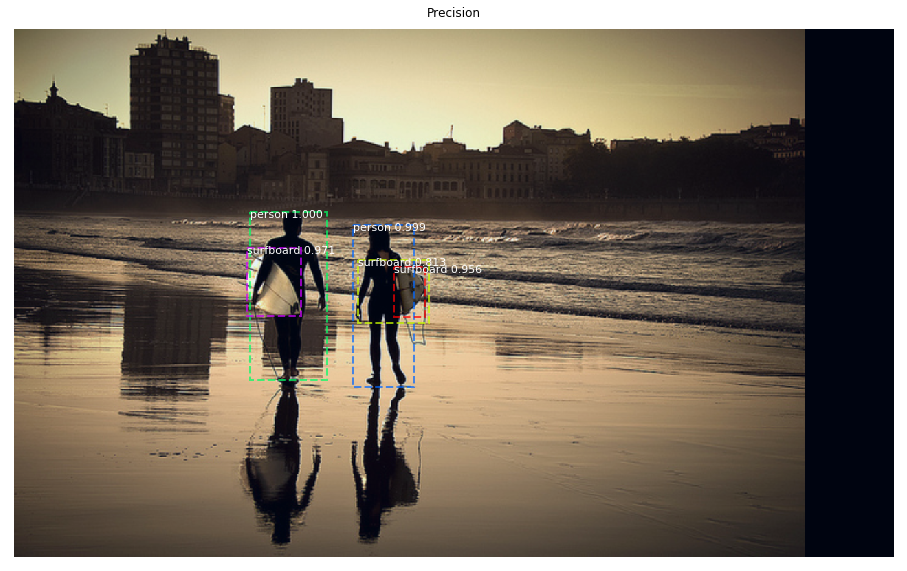

In [20]:
import random
import colorsys

import matplotlib.pyplot as plt
import matplotlib.patches as patches


set_seed(1)

def get_ax(rows=1, cols=1, size=16):
    """
    Set axis

    Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central
    point to control graph sizes.
    Adjust the size attribute to control how big to render images.

    Args:
        rows(int): row size. default: 1.
        cols(int): column size. default: 1.
        size(int): pixel size. default: 16.

    Returns:
        Array, array of Axes
    """
    _, axis = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return axis

def mindrecord_to_rgb(img_data):
    """
    Returns a RGB image from evaluated results.
    Args:
        rows(Array): a image.

    Returns:
        Array, a RGB image.
    """
    index = 0
    convert_img = (-np.min(img_data[index, :, :, :])+img_data[index, :, :, :]) *\
        255/(np.max(img_data[index, :, :, :])-np.min(img_data[index, :, :, :]))
    temp_img = convert_img.astype(np.uint8)
    image = np.zeros([config.img_height, config.img_width, 3])
    image[:, :, 0] = temp_img[0, :, :]
    image[:, :, 1] = temp_img[1, :, :]
    image[:, :, 2] = temp_img[2, :, :]
    return image

def random_colors(num, bright=True):
    """
    Generate random colors.

    To get visually distinct colors, generate them in HSV space then
    convert to RGB.

    Args:
        num(int): the color number.

    Returns:
        List, a list of different colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / num, 1, brightness) for i in range(num)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def infer():
    """
    Return Mask RCNN evaluated results.

    Returns:
        output, Mask RCNN evaluated result.
                [Tensor[2,80000,5],
                 Tensor[2,80000,1],
                 Tensor[2,80000,1]
                 Tensor[2,80000,28,28]]
        img, RGB image, (height, width, 3)
    """
    # load image
    device_target = config.device_target
    context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

    mindrecord_dir = os.path.join(config.data_root, config.mindrecord_dir)

    prefix = "MaskRcnn_eval.mindrecord"

    mindrecord_file = os.path.join(mindrecord_dir, prefix)

    dataset = create_coco_dataset(mindrecord_file, batch_size=config.test_batch_size, is_training=False)

    total = dataset.get_dataset_size()
    image_id = np.random.choice(total, 1)

    # load model
    ckpt_path = config.checkpoint_path
    net = MaskRcnnResnet50(config)
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)
    net.set_train(False)

    data = list(dataset.create_dict_iterator(output_numpy=True, num_epochs=1))[image_id[0]]
    print("Image ID: ", image_id[0])
    img_data = data['image']
    img_metas = data['image_shape']
    gt_bboxes = data['box']
    gt_labels = data['label']
    gt_num = data['valid_num']
    gt_mask = data["mask"]

    img = mindrecord_to_rgb(img_data)

    start = time.time()
    # run net
    output = net(Tensor(img_data), Tensor(img_metas), Tensor(gt_bboxes),
                 Tensor(gt_labels), Tensor(gt_num), Tensor(gt_mask))
    end = time.time()
    print("Cost time of detection: {:.2f}".format(end - start))
    return output, img, img_metas

def detection(output, img, img_metas):
    """Mask RCNN Detection.
    Arg:
        output, evaluated results by Mask RCNN.
               [Tensor[2,80000,5],
                Tensor[2,80000,1],
                Tensor[2,80000,1]
                Tensor[2,80000,28,28]]
        img, RGB image.
        img_metas, image shape.
    """
    # scaling ratio
    ratio = img_metas[0, 2]

    # output
    all_bbox = output[0][0].asnumpy()
    all_label = output[1][0].asnumpy()
    all_mask = output[2][0].asnumpy()

    num = 0
    mask_id = -1
    type_ids = []
    for bool_ in all_mask:
        mask_id += 1
        if np.equal(bool_, True) and all_bbox[mask_id, 4] > 0.8:
            type_ids.append(mask_id)
            num += 1
    print("Class Num:", num)

    # Generate random colors
    colors = random_colors(num)

    # Show area outside image boundaries.
    height = config.img_height
    width = config.img_width
    ax = get_ax(1)
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title("Precision")

    masked_image = img.astype(np.uint32).copy()
    for j in range(num):
        color = colors[j]
        i = type_ids[j]
        # Bounding box

        x1, y1, x2, y2, _ = all_bbox[i]*ratio
        score = all_bbox[i, 4]

        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                              linestyle="dashed", edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_names = config.data_classes
        class_id = all_label[i, 0].astype(np.uint8)+1
        score = all_bbox[i, 4]
        label = class_names[class_id]

        caption = "{} {:.3f}".format(label, score)
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

if __name__ == '__main__':
    out, img_rgb, img_shape = infer()
    detection(out, img_rgb, img_shape)

## 参考文献

[1] He K, Gkioxari G, Dollár P, et al. Mask r-cnn[C]//Proceedings of the IEEE international conference on computer vision. 2017: 2961-2969.